<a href="https://colab.research.google.com/github/apsotodiaz/tesis-Maixduino/blob/main/Copia_de_speaker_veri_gmm_ubm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# upload timit test dataset
! wget https://gitlab.com/brainekt/timit_test/-/raw/main/TIMIT_TEST.zip

--2024-03-01 21:08:12--  https://gitlab.com/brainekt/timit_test/-/raw/main/TIMIT_TEST.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116291884 (111M) [application/octet-stream]
Saving to: ‘TIMIT_TEST.zip.2’

TIMIT_TEST.zip.2    100%[===================>] 110.90M   145MB/s    in 0.8s    

2024-03-01 21:08:13 (145 MB/s) - ‘TIMIT_TEST.zip.2’ saved [116291884/116291884]



In [ ]:
# unzip the archive
! unzip TIMIT_TEST.zip

Archive:  TIMIT_TEST.zip
replace TEST/DR1/FAKS0/SA1.PHN? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
# make a speaker based dataset
from glob import glob

speakers_data = {}

for f in glob("TEST/*/*/*.WAV.wav"):
  speaker_id = f.split("/")[-3] + "_" + f.split("/")[-2]
  speakers_data[speaker_id] = speakers_data.get(speaker_id, []) + [f]

In [10]:
print(speakers_data)

{'DR1_MJSW0': ['TEST/DR1/MJSW0/SX20.WAV.wav', 'TEST/DR1/MJSW0/SI2270.WAV.wav', 'TEST/DR1/MJSW0/SX110.WAV.wav', 'TEST/DR1/MJSW0/SI1010.WAV.wav', 'TEST/DR1/MJSW0/SA2.WAV.wav', 'TEST/DR1/MJSW0/SX200.WAV.wav', 'TEST/DR1/MJSW0/SX380.WAV.wav', 'TEST/DR1/MJSW0/SI1640.WAV.wav', 'TEST/DR1/MJSW0/SA1.WAV.wav', 'TEST/DR1/MJSW0/SX290.WAV.wav'], 'DR1_FJEM0': ['TEST/DR1/FJEM0/SX184.WAV.wav', 'TEST/DR1/FJEM0/SX4.WAV.wav', 'TEST/DR1/FJEM0/SA2.WAV.wav', 'TEST/DR1/FJEM0/SI1894.WAV.wav', 'TEST/DR1/FJEM0/SX94.WAV.wav', 'TEST/DR1/FJEM0/SX274.WAV.wav', 'TEST/DR1/FJEM0/SI634.WAV.wav', 'TEST/DR1/FJEM0/SA1.WAV.wav', 'TEST/DR1/FJEM0/SX364.WAV.wav', 'TEST/DR1/FJEM0/SI1264.WAV.wav'], 'DR1_MRJO0': ['TEST/DR1/MRJO0/SX284.WAV.wav', 'TEST/DR1/MRJO0/SI734.WAV.wav', 'TEST/DR1/MRJO0/SX14.WAV.wav', 'TEST/DR1/MRJO0/SA2.WAV.wav', 'TEST/DR1/MRJO0/SI1364.WAV.wav', 'TEST/DR1/MRJO0/SX374.WAV.wav', 'TEST/DR1/MRJO0/SX104.WAV.wav', 'TEST/DR1/MRJO0/SA1.WAV.wav', 'TEST/DR1/MRJO0/SI1624.WAV.wav', 'TEST/DR1/MRJO0/SX194.WAV.wav'], 'DR1

In [8]:
print(speaker_id)

DR8_MAJC0


In [9]:
print(f"total speakers: {len(speakers_data)}")

total speakers: 168


In [ ]:
# install python_speech_features
! pip install python_speech_features
! pip install librosa

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5869 sha256=229feeb8f734b1aaf062820f334cac16677c5dab7a7368dad17d83cbff8766bb
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
from librosa.feature import delta as calc_delta


def extract_features(audio, rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines
    delta to make it 40 dim feature vector"""

    mfcc_feature = mfcc.mfcc(audio,rate, 0.025, 0.01, 20, nfft = 1200, appendEnergy = True)
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calc_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta))
    return combined

In [ ]:
# test
extract_features(np.random.randn(14000,), 16000).shape

(86, 40)

In [ ]:
print(extract_features(np.random.randn(14000,), 16000).shape)

(86, 40)


In [ ]:
# training GMM model
from scipy.io.wavfile import read
from sklearn.mixture import GaussianMixture as GMM
from tqdm import tqdm
# for each speaker train a GMM model

GMM_COMPONENTS = 5
gmm_speakers = {}

for speaker_id in tqdm(speakers_data):
  gmm = GMM(n_components = GMM_COMPONENTS, covariance_type='diag', n_init = 3)
  feature_vect = np.asarray(())

  for aud_path in speakers_data[speaker_id]:
    sr, speaker_aud = read(aud_path)
    speaker_feat = extract_features(speaker_aud, sr)
    if feature_vect.size == 0:
      feature_vect = speaker_feat
    else:
      feature_vect = np.vstack((feature_vect, speaker_feat))
  # train
  gmm.fit(feature_vect)
  # store the gmm
  gmm_speakers[speaker_id] = gmm

100%|██████████| 168/168 [02:53<00:00,  1.04s/it]


In [ ]:
# Iterar sobre los datos de los hablantes
for speaker_id in tqdm(speakers_data):
    gmm = GMM(n_components = GMM_COMPONENTS, covariance_type='diag', n_init = 3)
    feature_vect = np.asarray(())

    for aud_path in speakers_data[speaker_id]:
        sr, speaker_aud = read(aud_path)
        speaker_feat = extract_features(speaker_aud, sr)
        if feature_vect.size == 0:
            feature_vect = speaker_feat
        else:
            feature_vect = np.vstack((feature_vect, speaker_feat))

    # Entrenar el modelo GMM
    gmm.fit(feature_vect)

    # Almacenar el modelo GMM en el diccionario
    gmm_speakers[speaker_id] = gmm

    # Imprimir las características de cada hablante
    print("Características del hablante", speaker_id)
    print(feature_vect)

# Nombre del archivo donde se guardará el array
filename = 'feature_vect.txt'

# Guardar el array como un archivo de texto
np.savetxt(filename, feature_vect)

print(f"Las características han sido guardadas en el archivo {filename}")

  1%|          | 1/168 [00:00<01:32,  1.80it/s]

Características del hablante DR1_MJSW0
[[-1.48092141 -0.29371206 -1.04040427 ...  0.16396093  0.16396093
   0.16396093]
 [-1.48016168 -0.37094934 -0.82021968 ...  0.15960114  0.15960114
   0.15960114]
 [-1.47590745 -0.41844977 -0.50532517 ... -0.15853801 -0.15853801
  -0.15853801]
 ...
 [-2.04811972 -0.94187335  1.01563715 ... -0.05201647 -0.05201647
  -0.05201647]
 [-2.0611255  -0.89186846  1.1658706  ... -0.06625179 -0.06625179
  -0.06625179]
 [-2.12559699 -0.88864256  1.42500425 ...  0.04923619  0.04923619
   0.04923619]]


  1%|          | 2/168 [00:01<02:05,  1.32it/s]

Características del hablante DR1_FJEM0
[[-2.31622579 -0.95722575  0.52206895 ... -0.12934041 -0.12934041
  -0.12934041]
 [-2.35557659 -1.04742207  0.35474992 ... -0.15471831 -0.15471831
  -0.15471831]
 [-2.36700036 -1.08328765  0.41565405 ... -0.09016716 -0.09016716
  -0.09016716]
 ...
 [-2.19849781 -0.88412383  0.62205061 ...  0.03931875  0.03931875
   0.03931875]
 [-2.02292934 -0.72130835  0.18038095 ... -0.04212091 -0.04212091
  -0.04212091]
 [-2.07414754 -0.65111015  0.23593309 ...  0.01696028  0.01696028
   0.01696028]]


  2%|▏         | 3/168 [00:02<01:53,  1.45it/s]

Características del hablante DR1_MRJO0
[[-2.2326945  -0.58158705 -0.05688788 ... -0.00497496 -0.00497496
  -0.00497496]
 [-2.32233993 -0.5599358   0.15434673 ... -0.00747194 -0.00747194
  -0.00747194]
 [-2.47368516 -0.54847614  0.56648461 ...  0.09299809  0.09299809
   0.09299809]
 ...
 [-1.76598392 -0.58398304  0.46686089 ...  0.17720149  0.17720149
   0.17720149]
 [-1.79328886 -0.50322236  0.71864257 ...  0.08523928  0.08523928
   0.08523928]
 [-1.96473108 -0.46868788  1.02884671 ...  0.00800564  0.00800564
   0.00800564]]


  2%|▏         | 4/168 [00:02<02:03,  1.32it/s]

Características del hablante DR1_FAKS0
[[-1.55371063 -0.68838399  0.19704065 ...  0.02757618  0.02757618
   0.02757618]
 [-1.55116328 -0.74188712  0.01894756 ... -0.02843785 -0.02843785
  -0.02843785]
 [-1.53545978 -0.76094048  0.10778976 ... -0.02857314 -0.02857314
  -0.02857314]
 ...
 [-2.06417535 -0.36618756  0.49973762 ... -0.17554703 -0.17554703
  -0.17554703]
 [-2.10619232 -0.47777773  0.51877484 ... -0.18484059 -0.18484059
  -0.18484059]
 [-2.20965978 -0.42525455  0.59281897 ... -0.17002238 -0.17002238
  -0.17002238]]


  3%|▎         | 5/168 [00:03<01:52,  1.45it/s]

Características del hablante DR1_MSJS1
[[-2.08208763e+00 -5.21970876e-01  4.97503961e-01 ...  2.39161290e-02
   2.39161290e-02  2.39161290e-02]
 [-2.07841862e+00 -5.12603402e-01  4.68316985e-02 ... -1.00483520e-01
  -1.00483520e-01 -1.00483520e-01]
 [-2.09115531e+00 -5.61831607e-01 -4.60493157e-02 ... -1.63774467e-03
  -1.63774467e-03 -1.63774467e-03]
 ...
 [-1.86385549e+00 -8.84805415e-01  6.40619199e-01 ... -2.07163417e-01
  -2.07163417e-01 -2.07163417e-01]
 [-1.88111820e+00 -9.69765453e-01  5.48855265e-01 ... -1.46147238e-01
  -1.46147238e-01 -1.46147238e-01]
 [-1.90359681e+00 -9.16315726e-01  7.16214828e-01 ...  1.13854574e-01
   1.13854574e-01  1.13854574e-01]]


  4%|▎         | 6/168 [00:05<02:41,  1.01it/s]

Características del hablante DR1_MREB0
[[-2.07334663 -0.98891686  0.78028784 ...  0.28544646  0.28544646
   0.28544646]
 [-2.06673313 -1.00339901  0.90022855 ...  0.29310372  0.29310372
   0.29310372]
 [-2.10119291 -0.86193852  1.05474627 ...  0.1001721   0.1001721
   0.1001721 ]
 ...
 [-2.20317884 -0.73242084  1.05829535 ...  0.03311203  0.03311203
   0.03311203]
 [-2.22908019 -0.8477909   1.02703389 ...  0.02480628  0.02480628
   0.02480628]
 [-2.35938552 -0.99829215  1.15115162 ... -0.01227013 -0.01227013
  -0.01227013]]


  4%|▍         | 7/168 [00:06<03:07,  1.16s/it]

Características del hablante DR1_MDAB0
[[-1.45427354 -0.70475934 -1.86016835 ...  0.11843753  0.11843753
   0.11843753]
 [-1.65367535 -0.58003379 -0.96668309 ...  0.22420238  0.22420238
   0.22420238]
 [-1.70613555 -0.66054985 -1.40066096 ...  0.18618606  0.18618606
   0.18618606]
 ...
 [-2.13602765  0.02398824 -0.39595883 ... -0.02018407 -0.02018407
  -0.02018407]
 [-2.15940747 -0.02425354 -0.31078929 ... -0.01449604 -0.01449604
  -0.01449604]
 [-2.26346706 -0.01096512 -0.0507521  ...  0.11882589  0.11882589
   0.11882589]]


  5%|▍         | 8/168 [00:06<02:27,  1.09it/s]

Características del hablante DR1_MSTK0
[[-1.78974169 -0.74274761  0.58860054 ...  0.01272928  0.01272928
   0.01272928]
 [-1.75548174 -0.82198746  0.43518126 ... -0.04629388 -0.04629388
  -0.04629388]
 [-1.72666043 -0.8662483   0.47344825 ...  0.05087682  0.05087682
   0.05087682]
 ...
 [-2.01615917 -0.60861866 -0.55016631 ...  0.115402    0.115402
   0.115402  ]
 [-2.03010648 -1.01882841 -0.8542605  ...  0.05390867  0.05390867
   0.05390867]
 [-2.23248022 -1.04720664 -0.33250878 ...  0.03915005  0.03915005
   0.03915005]]


  5%|▌         | 9/168 [00:07<02:18,  1.15it/s]

Características del hablante DR1_FELC0
[[-2.05689077 -1.18279775 -0.26173199 ...  0.07813356  0.07813356
   0.07813356]
 [-2.04715572 -1.01921362  0.24743027 ...  0.02799555  0.02799555
   0.02799555]
 [-2.02411095 -1.17967616 -0.03877641 ...  0.04634556  0.04634556
   0.04634556]
 ...
 [-1.84411278 -1.42201315 -0.01325556 ...  0.02561868  0.02561868
   0.02561868]
 [-1.85076155 -1.31327012  0.17124037 ... -0.13612926 -0.13612926
  -0.13612926]
 [-2.18559509 -1.06390537  0.26280108 ... -0.0821794  -0.0821794
  -0.0821794 ]]


  6%|▌         | 10/168 [00:08<02:16,  1.15it/s]

Características del hablante DR1_FDAC1
[[-1.69308171 -0.13097134  0.37171444 ... -0.07826864 -0.07826864
  -0.07826864]
 [-1.69325053 -0.12714013  0.45048362 ...  0.01388977  0.01388977
   0.01388977]
 [-1.7378801  -0.34329172  0.14816642 ...  0.16514009  0.16514009
   0.16514009]
 ...
 [-2.15772398 -1.10472539  0.14082485 ... -0.00438389 -0.00438389
  -0.00438389]
 [-2.17259021 -1.09054177  0.19076845 ...  0.07263437  0.07263437
   0.07263437]
 [-2.26181406 -0.9998338   0.41463946 ...  0.11529831  0.11529831
   0.11529831]]


  7%|▋         | 11/168 [00:09<02:18,  1.14it/s]

Características del hablante DR1_MWBT0
[[-2.01301822 -1.37901005  1.22473927 ...  0.17483699  0.17483699
   0.17483699]
 [-1.97101781 -1.30774236  1.34436441 ...  0.09866057  0.09866057
   0.09866057]
 [-1.97265979 -1.1934021   1.28056419 ...  0.10828838  0.10828838
   0.10828838]
 ...
 [-1.69729649 -0.38475034  0.9405595  ... -0.06438517 -0.06438517
  -0.06438517]
 [-1.69916536 -0.35644403  0.87346403 ... -0.04526589 -0.04526589
  -0.04526589]
 [-1.75215257 -0.34018365  0.96139101 ... -0.16287405 -0.16287405
  -0.16287405]]


  7%|▋         | 12/168 [00:10<02:15,  1.15it/s]

Características del hablante DR7_MRMS1
[[-2.08521998 -1.19444694  0.57692611 ... -0.09377526 -0.09377526
  -0.09377526]
 [-2.09941989 -1.15339818  0.42460636 ... -0.14118941 -0.14118941
  -0.14118941]
 [-2.07976068 -0.92958368 -0.08375015 ... -0.03757343 -0.03757343
  -0.03757343]
 ...
 [-1.84394652 -1.15179877  0.17104332 ... -0.01160714 -0.01160714
  -0.01160714]
 [-1.93543975 -0.93805874  0.20529037 ... -0.00225889 -0.00225889
  -0.00225889]
 [-1.95084889 -0.96582254  0.1382709  ...  0.07736282  0.07736282
   0.07736282]]


  8%|▊         | 13/168 [00:11<02:07,  1.21it/s]

Características del hablante DR7_MRCS0
[[-2.02724099 -1.07346359 -0.23627592 ... -0.08490852 -0.08490852
  -0.08490852]
 [-2.13036638 -1.06242312 -0.30697872 ... -0.09307134 -0.09307134
  -0.09307134]
 [-2.13258981 -0.9729607   0.18217383 ... -0.14655758 -0.14655758
  -0.14655758]
 ...
 [-1.32434989 -0.45803075 -1.47895472 ...  0.04116178  0.04116178
   0.04116178]
 [-1.54017337 -0.27484635 -0.51011066 ...  0.10567777  0.10567777
   0.10567777]
 [-1.66877811 -0.52674082 -0.76176116 ...  0.12617463  0.12617463
   0.12617463]]


  8%|▊         | 14/168 [00:11<01:57,  1.31it/s]

Características del hablante DR7_MERS0
[[-1.24339953 -0.8482909   0.34282078 ...  0.08758404  0.08758404
   0.08758404]
 [-1.25538043 -0.78266872  0.59151692 ...  0.00425142  0.00425142
   0.00425142]
 [-1.22783326 -0.90449522  0.84941449 ... -0.07255974 -0.07255974
  -0.07255974]
 ...
 [-1.57172329 -1.20610599  0.43776103 ...  0.14272102  0.14272102
   0.14272102]
 [-1.58008628 -1.23441744  0.6823437  ... -0.02325025 -0.02325025
  -0.02325025]
 [-1.69987893 -1.29792637  0.87044826 ... -0.10434508 -0.10434508
  -0.10434508]]


  9%|▉         | 15/168 [00:12<01:55,  1.32it/s]

Características del hablante DR7_FCAU0
[[-1.91212293e+00 -6.55453384e-01 -1.67200342e-01 ...  1.88626930e-01
   1.88626930e-01  1.88626930e-01]
 [-2.00485721e+00 -5.84028102e-01 -1.39592281e-01 ...  1.17734315e-01
   1.17734315e-01  1.17734315e-01]
 [-2.04048345e+00 -6.15551989e-01 -1.27941641e-01 ...  8.41991715e-05
   8.41991715e-05  8.41991715e-05]
 ...
 [-2.17250531e+00 -9.57419846e-01  2.80093933e-01 ... -9.50509295e-02
  -9.50509295e-02 -9.50509295e-02]
 [-2.16395881e+00 -1.00020032e+00  1.65317483e-01 ... -2.21543862e-03
  -2.21543862e-03 -2.21543862e-03]
 [-2.20747636e+00 -9.36670835e-01  1.09142500e-01 ... -9.50749935e-02
  -9.50749935e-02 -9.50749935e-02]]


 10%|▉         | 16/168 [00:13<01:49,  1.39it/s]

Características del hablante DR7_MKDR0
[[-1.77235064 -0.85474654 -0.32921935 ... -0.07756913 -0.07756913
  -0.07756913]
 [-1.87669226 -0.79671452 -0.34801578 ... -0.01539733 -0.01539733
  -0.01539733]
 [-1.98243929 -0.95547573 -0.20549139 ...  0.06371193  0.06371193
   0.06371193]
 ...
 [-1.6805947  -1.02090918  0.51768613 ...  0.11277145  0.11277145
   0.11277145]
 [-1.65302665 -1.09405998  0.53985467 ... -0.01842775 -0.01842775
  -0.01842775]
 [-1.66368768 -1.09763274  0.51446732 ...  0.21719329  0.21719329
   0.21719329]]


 10%|█         | 17/168 [00:13<01:47,  1.41it/s]

Características del hablante DR7_FMML0
[[-2.13687482 -1.07979001  0.70012039 ... -0.04815958 -0.04815958
  -0.04815958]
 [-2.13693921 -1.19394901  0.61802687 ... -0.04117973 -0.04117973
  -0.04117973]
 [-2.13860706 -1.16944521  0.46624517 ... -0.16867325 -0.16867325
  -0.16867325]
 ...
 [-1.41933206 -1.12886298  0.79609957 ...  0.09535909  0.09535909
   0.09535909]
 [-1.44797026 -1.04125316  0.76012589 ...  0.02011987  0.02011987
   0.02011987]
 [-1.48500977 -1.1333309   0.59977709 ...  0.03303273  0.03303273
   0.03303273]]


 11%|█         | 18/168 [00:14<01:47,  1.39it/s]

Características del hablante DR7_FDHC0
[[-1.88193443e+00 -8.81847357e-01 -1.27625445e+00 ... -2.61123865e-02
  -2.61123865e-02 -2.61123865e-02]
 [-2.04084218e+00 -7.30339127e-01 -1.16271558e+00 ... -1.64631141e-02
  -1.64631141e-02 -1.64631141e-02]
 [-2.29595261e+00 -7.47148029e-01 -7.78844419e-01 ...  2.61307431e-02
   2.61307431e-02  2.61307431e-02]
 ...
 [-1.77130652e+00 -1.43316778e+00  8.42690068e-02 ...  4.04806767e-02
   4.04806767e-02  4.04806767e-02]
 [-1.77489513e+00 -1.53915707e+00  5.95161207e-03 ...  1.28627709e-01
   1.28627709e-01  1.28627709e-01]
 [-1.89598580e+00 -1.39907345e+00  2.78798516e-01 ...  1.00850719e-03
   1.00850719e-03  1.00850719e-03]]


 11%|█▏        | 19/168 [00:15<02:01,  1.23it/s]

Características del hablante DR7_FGWR0
[[-1.64775618 -0.88776647  0.77105618 ...  0.01484195  0.01484195
   0.01484195]
 [-1.6553337  -0.87121066  0.79745405 ... -0.00297825 -0.00297825
  -0.00297825]
 [-1.63222173 -0.97955356  0.66128252 ...  0.12803677  0.12803677
   0.12803677]
 ...
 [-2.31849494 -0.29799302  1.02644944 ... -0.12754591 -0.12754591
  -0.12754591]
 [-2.33950084 -0.36670001  1.09353068 ... -0.19651472 -0.19651472
  -0.19651472]
 [-2.31370009 -0.53997866  1.15446401 ... -0.00852365 -0.00852365
  -0.00852365]]


 12%|█▏        | 20/168 [00:16<01:58,  1.25it/s]

Características del hablante DR7_MNJM0
[[-1.6602741  -1.3126392   0.32428591 ... -0.06180887 -0.06180887
  -0.06180887]
 [-1.69378704 -1.244424    0.45082488 ... -0.02422281 -0.02422281
  -0.02422281]
 [-1.67636357 -1.39697725  0.8275745  ... -0.02852564 -0.02852564
  -0.02852564]
 ...
 [-1.90670389 -0.35369992  0.06399802 ... -0.02441723 -0.02441723
  -0.02441723]
 [-1.94746884 -0.28548111  0.15013943 ... -0.04591452 -0.04591452
  -0.04591452]
 [-1.99124378 -0.29299818  0.4290628  ...  0.12551584  0.12551584
   0.12551584]]


 12%|█▎        | 21/168 [00:17<02:15,  1.08it/s]

Características del hablante DR7_MDLF0
[[-1.98016139 -0.54512577  0.08672077 ... -0.02206522 -0.02206522
  -0.02206522]
 [-1.96749507 -0.45010231 -0.03039336 ...  0.00764555  0.00764555
   0.00764555]
 [-1.96929333 -0.40801627 -0.13677864 ...  0.0494499   0.0494499
   0.0494499 ]
 ...
 [-2.10029371 -1.17366148  0.88760372 ...  0.01636742  0.01636742
   0.01636742]
 [-2.12175644 -1.2740446   0.78222073 ... -0.11474785 -0.11474785
  -0.11474785]
 [-2.23483209 -1.10465064  1.22960789 ... -0.22858213 -0.22858213
  -0.22858213]]


 13%|█▎        | 22/168 [00:19<02:41,  1.11s/it]

Características del hablante DR7_MCHH0
[[-1.58884184 -0.4014563  -0.67685874 ... -0.10005349 -0.10005349
  -0.10005349]
 [-1.71693444 -0.30219988 -0.57285855 ... -0.05829942 -0.05829942
  -0.05829942]
 [-1.78802912 -0.32657421 -0.1967032  ...  0.11080288  0.11080288
   0.11080288]
 ...
 [-1.58245202 -0.72681583 -0.31388875 ...  0.2334451   0.2334451
   0.2334451 ]
 [-1.62162478 -0.46591421  0.33845237 ...  0.15286486  0.15286486
   0.15286486]
 [-1.81195636 -0.54914898  0.23768125 ...  0.08807059  0.08807059
   0.08807059]]


 14%|█▎        | 23/168 [00:20<02:37,  1.09s/it]

Características del hablante DR7_MKJL0
[[-1.47256946 -1.15742116  0.67694578 ... -0.06674743 -0.06674743
  -0.06674743]
 [-1.54581494 -1.16514718  0.65406309 ...  0.01033669  0.01033669
   0.01033669]
 [-1.57728024 -0.91120329  1.1384324  ... -0.06672638 -0.06672638
  -0.06672638]
 ...
 [-1.83841179 -0.26513697  0.93328266 ...  0.05960285  0.05960285
   0.05960285]
 [-2.04680209 -0.41838333  1.04835524 ...  0.08647234  0.08647234
   0.08647234]
 [-2.09530445 -0.61698621  0.94116475 ... -0.01770602 -0.01770602
  -0.01770602]]


 14%|█▍        | 24/168 [00:20<02:24,  1.00s/it]

Características del hablante DR7_MGRT0
[[-1.2093938  -0.82620013  0.46817401 ...  0.05707724  0.05707724
   0.05707724]
 [-1.19047429 -0.86658483  0.42767254 ...  0.11017415  0.11017415
   0.11017415]
 [-1.22434895 -0.87289407  0.19154765 ...  0.22736357  0.22736357
   0.22736357]
 ...
 [-2.33691137 -0.16222816 -0.23676791 ... -0.02860276 -0.02860276
  -0.02860276]
 [-2.3915209  -0.27775921 -0.26245745 ...  0.0750253   0.0750253
   0.0750253 ]
 [-2.40434066 -0.3460772  -0.33672494 ... -0.01766026 -0.01766026
  -0.01766026]]


 15%|█▍        | 25/168 [00:21<02:10,  1.09it/s]

Características del hablante DR7_MRPC0
[[-2.03390156 -0.95406995  0.62446023 ...  0.06756209  0.06756209
   0.06756209]
 [-2.0226061  -0.85301103  0.48973252 ... -0.12112678 -0.12112678
  -0.12112678]
 [-1.97780306 -0.72723417  0.55337516 ...  0.00936531  0.00936531
   0.00936531]
 ...
 [-1.43374011 -0.20027186  0.869338   ...  0.04440072  0.04440072
   0.04440072]
 [-1.3554346  -0.42982453  0.40382228 ...  0.01251251  0.01251251
   0.01251251]
 [-1.33744872 -0.69167993 -0.24192022 ... -0.05471328 -0.05471328
  -0.05471328]]


 15%|█▌        | 26/168 [00:22<01:58,  1.20it/s]

Características del hablante DR7_MRJM4
[[-1.53337333 -1.28196699  0.39959786 ... -0.00921578 -0.00921578
  -0.00921578]
 [-1.54175407 -1.2453155   0.39898482 ... -0.01276358 -0.01276358
  -0.01276358]
 [-1.58777883 -1.20784123  0.28912992 ...  0.00996588  0.00996588
   0.00996588]
 ...
 [-2.15083135 -0.50854321  0.56470407 ...  0.15405075  0.15405075
   0.15405075]
 [-2.17655145 -0.67462152  0.33797039 ...  0.1503762   0.1503762
   0.1503762 ]
 [-2.36873487 -0.68982159  0.63375362 ...  0.11869151  0.11869151
   0.11869151]]


 16%|█▌        | 27/168 [00:22<01:51,  1.27it/s]

Características del hablante DR7_MTWH0
[[-1.78392572 -0.88362841  0.50343646 ...  0.13621985  0.13621985
   0.13621985]
 [-1.82634841 -0.86440112  0.71145651 ...  0.06749347  0.06749347
   0.06749347]
 [-1.79897499 -1.00583201  0.51190765 ... -0.01656949 -0.01656949
  -0.01656949]
 ...
 [-1.95455295 -0.92706421  0.22571576 ...  0.23071804  0.23071804
   0.23071804]
 [-1.98703962 -0.91438078  0.48870485 ...  0.04840815  0.04840815
   0.04840815]
 [-2.31976141 -0.84507297  0.30979321 ...  0.0684407   0.0684407
   0.0684407 ]]


 17%|█▋        | 28/168 [00:23<01:50,  1.26it/s]

Características del hablante DR7_FLAS0
[[-1.63835265 -0.76487376  0.49043386 ... -0.07794166 -0.07794166
  -0.07794166]
 [-1.69855725 -0.83805556  0.50089867 ... -0.12840815 -0.12840815
  -0.12840815]
 [-1.70385091 -0.924338    0.54788383 ...  0.0455743   0.0455743
   0.0455743 ]
 ...
 [-1.76692294 -0.83519946  0.17667763 ... -0.04130506 -0.04130506
  -0.04130506]
 [-1.8344348  -0.94816132  0.22143815 ... -0.16427262 -0.16427262
  -0.16427262]
 [-1.91841868 -0.96599672  0.09967637 ... -0.23272825 -0.23272825
  -0.23272825]]


 17%|█▋        | 29/168 [00:24<01:41,  1.37it/s]

Características del hablante DR7_FSXA0
[[-1.63139854 -0.48627829  1.07480586 ...  0.17741092  0.17741092
   0.17741092]
 [-1.59534285 -1.06022735  0.19860534 ... -0.10902709 -0.10902709
  -0.10902709]
 [-1.54973662 -1.20157366  0.01730247 ...  0.04380201  0.04380201
   0.04380201]
 ...
 [-2.23707946 -0.76121291 -0.07722861 ...  0.06159786  0.06159786
   0.06159786]
 [-2.27836042 -0.83231383 -0.4497666  ...  0.08816345  0.08816345
   0.08816345]
 [-2.26105235 -0.65749994 -0.38080276 ...  0.04309327  0.04309327
   0.04309327]]


 18%|█▊        | 30/168 [00:24<01:32,  1.49it/s]

Características del hablante DR7_MNLS0
[[-1.83309623 -0.65276295 -0.97450659 ...  0.01749107  0.01749107
   0.01749107]
 [-1.92394191 -0.46076013 -0.75636891 ... -0.05466999 -0.05466999
  -0.05466999]
 [-1.99672941 -0.56444409 -1.02616319 ... -0.1190314  -0.1190314
  -0.1190314 ]
 ...
 [-2.00474529 -0.7023394   0.25178009 ...  0.02029796  0.02029796
   0.02029796]
 [-2.05712016 -0.79732254  0.3169308  ... -0.1003116  -0.1003116
  -0.1003116 ]
 [-2.17676214 -0.66963123  0.85795719 ... -0.09587572 -0.09587572
  -0.09587572]]


 18%|█▊        | 31/168 [00:25<01:36,  1.42it/s]

Características del hablante DR7_MPAB0
[[-1.58709499e+00 -9.05891849e-01  2.75932444e-01 ...  7.68290710e-02
   7.68290710e-02  7.68290710e-02]
 [-1.54526750e+00 -9.36681532e-01  3.26618095e-01 ...  1.45656810e-01
   1.45656810e-01  1.45656810e-01]
 [-1.54373949e+00 -1.01230004e+00  2.24176295e-01 ...  1.39880835e-01
   1.39880835e-01  1.39880835e-01]
 ...
 [-1.74344380e+00 -7.80631673e-01 -6.94431501e-01 ... -3.94066395e-05
  -3.94066395e-05 -3.94066395e-05]
 [-1.77050425e+00 -8.83358231e-01 -5.79351918e-01 ... -5.85948804e-03
  -5.85948804e-03 -5.85948804e-03]
 [-1.89390363e+00 -1.04485646e+00 -2.99299567e-01 ... -2.97748372e-02
  -2.97748372e-02 -2.97748372e-02]]


 19%|█▉        | 32/168 [00:26<01:38,  1.38it/s]

Características del hablante DR7_FISB0
[[-1.77790192e+00 -6.68974310e-01  3.65030793e-01 ... -1.45348598e-03
  -1.45348598e-03 -1.45348598e-03]
 [-1.79827849e+00 -8.00676289e-01  6.12772370e-01 ... -1.22437011e-01
  -1.22437011e-01 -1.22437011e-01]
 [-1.81731560e+00 -8.20265616e-01  4.72814306e-01 ... -1.64352744e-01
  -1.64352744e-01 -1.64352744e-01]
 ...
 [-1.56020157e+00 -4.34169281e-01 -4.56912695e-01 ... -1.65980643e-02
  -1.65980643e-02 -1.65980643e-02]
 [-1.60517190e+00 -4.90998955e-01 -4.51816954e-01 ... -3.40460433e-02
  -3.40460433e-02 -3.40460433e-02]
 [-1.72532945e+00 -5.04205655e-01 -4.23149908e-01 ... -9.51975327e-02
  -9.51975327e-02 -9.51975327e-02]]


 20%|█▉        | 33/168 [00:27<01:46,  1.27it/s]

Características del hablante DR7_FTLH0
[[-1.60079581 -0.58625193 -0.63177436 ... -0.09498162 -0.09498162
  -0.09498162]
 [-1.67617126 -0.54819636 -0.44080436 ...  0.10456877  0.10456877
   0.10456877]
 [-1.73344887 -0.54830096 -0.22564432 ... -0.09186376 -0.09186376
  -0.09186376]
 ...
 [-1.80823196 -0.99931555  0.46819816 ... -0.0028491  -0.0028491
  -0.0028491 ]
 [-1.8227464  -1.01633985  0.52157741 ...  0.04607262  0.04607262
   0.04607262]
 [-1.88675276 -1.12569828  0.34676417 ... -0.06289095 -0.06289095
  -0.06289095]]


 20%|██        | 34/168 [00:28<01:43,  1.29it/s]

Características del hablante DR7_MDVC0
[[-2.34691068e+00 -9.44432748e-01  8.49933622e-01 ... -1.76668601e-03
  -1.76668601e-03 -1.76668601e-03]
 [-2.32927065e+00 -6.72647895e-01  7.16042790e-01 ... -3.62787864e-02
  -3.62787864e-02 -3.62787864e-02]
 [-2.28870286e+00 -6.30606578e-01  2.11291386e-01 ...  1.50945632e-02
   1.50945632e-02  1.50945632e-02]
 ...
 [-1.66459680e+00 -1.43770653e-01  5.61751673e-01 ... -1.20248323e-01
  -1.20248323e-01 -1.20248323e-01]
 [-1.70914899e+00 -1.64782447e-01  1.17213030e+00 ... -9.78990253e-02
  -9.78990253e-02 -9.78990253e-02]
 [-1.81669303e+00 -2.04820613e-01  1.59267294e+00 ... -1.89713659e-01
  -1.89713659e-01 -1.89713659e-01]]


 21%|██        | 35/168 [00:28<01:34,  1.40it/s]

Características del hablante DR2_MWVW0
[[-2.2353597  -1.05258743  0.5584484  ... -0.01677709 -0.01677709
  -0.01677709]
 [-2.24173022 -1.13642299  0.58594874 ... -0.12294339 -0.12294339
  -0.12294339]
 [-1.94903301 -0.59312022  0.93810045 ... -0.08993937 -0.08993937
  -0.08993937]
 ...
 [-1.80637845 -0.53889756  0.22379686 ... -0.10117402 -0.10117402
  -0.10117402]
 [-1.82799973 -0.5381257   0.32937389 ... -0.1174376  -0.1174376
  -0.1174376 ]
 [-1.91215719 -0.61018422  0.26873291 ...  0.02440292  0.02440292
   0.02440292]]


 21%|██▏       | 36/168 [00:29<01:38,  1.34it/s]

Características del hablante DR2_FCMR0
[[-1.70040644 -1.14921471 -0.68953319 ... -0.12154677 -0.12154677
  -0.12154677]
 [-1.785551   -1.02975219  0.20991384 ... -0.09481336 -0.09481336
  -0.09481336]
 [-1.73450709 -1.46531091 -0.26200541 ... -0.10080322 -0.10080322
  -0.10080322]
 ...
 [-1.49528404 -0.25479784 -1.06203659 ...  0.00663902  0.00663902
   0.00663902]
 [-1.53804975 -0.24693189 -0.99984508 ...  0.05506012  0.05506012
   0.05506012]
 [-1.74142545 -0.39240712 -0.96942206 ... -0.07565183 -0.07565183
  -0.07565183]]


 22%|██▏       | 37/168 [00:31<02:12,  1.01s/it]

Características del hablante DR2_MTMR0
[[-1.67193158 -1.30907849  0.56105884 ...  0.0132108   0.0132108
   0.0132108 ]
 [-1.7344258  -1.15358109  0.6374494  ... -0.01357322 -0.01357322
  -0.01357322]
 [-1.73887206 -1.13183937  0.7554872  ...  0.0115676   0.0115676
   0.0115676 ]
 ...
 [-1.87098073 -0.59674491 -0.22178354 ...  0.10045159  0.10045159
   0.10045159]
 [-1.87025433 -0.81302786 -0.80420568 ...  0.01478895  0.01478895
   0.01478895]
 [-1.97609876 -0.63555366 -0.46191782 ...  0.05249053  0.05249053
   0.05249053]]


 23%|██▎       | 38/168 [00:32<02:18,  1.07s/it]

Características del hablante DR2_FRAM1
[[-1.59918351 -0.7979211   0.23865007 ... -0.05497051 -0.05497051
  -0.05497051]
 [-1.59053506 -0.81491577  0.30502226 ... -0.14000935 -0.14000935
  -0.14000935]
 [-1.6040311  -0.80644395  0.24516896 ... -0.01281483 -0.01281483
  -0.01281483]
 ...
 [-2.52428935 -0.59576944  0.39284718 ... -0.12801255 -0.12801255
  -0.12801255]
 [-2.52154134 -0.63694379  0.36317115 ...  0.02053395  0.02053395
   0.02053395]
 [-2.5774034  -0.46884356  0.64563307 ... -0.10923622 -0.10923622
  -0.10923622]]


 23%|██▎       | 39/168 [00:33<02:04,  1.03it/s]

Características del hablante DR2_FDRD1
[[-1.72714786e+00 -8.20245001e-01  2.14646155e-01 ... -3.84284002e-02
  -3.84284002e-02 -3.84284002e-02]
 [-1.68952584e+00 -1.09020952e+00  3.65536566e-01 ... -2.94740110e-02
  -2.94740110e-02 -2.94740110e-02]
 [-1.72356320e+00 -1.21762142e+00  5.31794563e-01 ... -3.33335130e-02
  -3.33335130e-02 -3.33335130e-02]
 ...
 [-1.41352225e+00 -8.39381935e-01 -6.20465525e-01 ...  1.26329802e-01
   1.26329802e-01  1.26329802e-01]
 [-1.73967411e+00 -7.03658427e-01  4.73344627e-01 ... -7.14585499e-03
  -7.14585499e-03 -7.14585499e-03]
 [-1.87581696e+00 -9.25786847e-01  7.23977698e-01 ...  1.76582579e-03
   1.76582579e-03  1.76582579e-03]]


 24%|██▍       | 40/168 [00:33<01:55,  1.11it/s]

Características del hablante DR2_MPGL0
[[-1.54961827e+00 -3.56266969e-01 -9.63657483e-01 ...  8.86857541e-02
   8.86857541e-02  8.86857541e-02]
 [-1.59821043e+00 -2.73309166e-01 -7.38741826e-01 ...  3.20337044e-02
   3.20337044e-02  3.20337044e-02]
 [-1.68311814e+00 -3.94236344e-01 -9.35596596e-01 ...  2.20850859e-02
   2.20850859e-02  2.20850859e-02]
 ...
 [-2.19896163e+00 -4.65980998e-02 -3.76600443e-02 ... -4.57316082e-02
  -4.57316082e-02 -4.57316082e-02]
 [-2.22342183e+00  4.98097866e-02  1.40799105e-03 ... -1.76813535e-02
  -1.76813535e-02 -1.76813535e-02]
 [-2.36040427e+00  1.45976158e-01  2.85848923e-01 ...  4.11816859e-02
   4.11816859e-02  4.11816859e-02]]


 24%|██▍       | 41/168 [00:34<01:52,  1.13it/s]

Características del hablante DR2_MCCS0
[[-1.17423233e+00 -7.03423516e-01  4.68667953e-01 ...  2.01179827e-01
   2.01179827e-01  2.01179827e-01]
 [-1.16531608e+00 -6.90262445e-01  3.69812637e-01 ...  1.15651151e-01
   1.15651151e-01  1.15651151e-01]
 [-1.15400466e+00 -6.04094030e-01  4.99881145e-01 ... -1.19619471e-01
  -1.19619471e-01 -1.19619471e-01]
 ...
 [-1.38029054e+00 -9.76762871e-01  9.97966026e-01 ... -7.35067229e-02
  -7.35067229e-02 -7.35067229e-02]
 [-1.36310279e+00 -1.14377910e+00  9.05888807e-01 ... -9.66288787e-02
  -9.66288787e-02 -9.66288787e-02]
 [-1.48144813e+00 -1.14173873e+00  1.14845091e+00 ... -2.34147433e-04
  -2.34147433e-04 -2.34147433e-04]]


 25%|██▌       | 42/168 [00:35<01:50,  1.14it/s]

Características del hablante DR2_FJRE0
[[-1.7304727  -0.3331091  -1.04365132 ...  0.03816491  0.03816491
   0.03816491]
 [-1.77801754 -0.43965405 -0.6968764  ... -0.18279229 -0.18279229
  -0.18279229]
 [-1.8119605  -0.44467098 -0.59096915 ... -0.01764251 -0.01764251
  -0.01764251]
 ...
 [-1.97128014 -0.62206284 -0.34316415 ... -0.11987407 -0.11987407
  -0.11987407]
 [-1.98589127 -0.72324393 -0.39627659 ... -0.10171559 -0.10171559
  -0.10171559]
 [-2.07413293 -0.76346866 -0.20854104 ...  0.10998818  0.10998818
   0.10998818]]


 26%|██▌       | 43/168 [00:36<01:50,  1.13it/s]

Características del hablante DR2_MRGG0
[[-2.02937804 -0.72783865  0.34938726 ... -0.10431718 -0.10431718
  -0.10431718]
 [-2.0814651  -0.92935723 -0.12994298 ... -0.17714128 -0.17714128
  -0.17714128]
 [-2.05861799 -1.00405929 -0.17535573 ... -0.08400051 -0.08400051
  -0.08400051]
 ...
 [-2.01984925 -1.25951094 -0.11392782 ...  0.15241143  0.15241143
   0.15241143]
 [-2.05120193 -1.21778467  0.11637656 ...  0.0417102   0.0417102
   0.0417102 ]
 [-2.06301348 -1.27776807 -0.07460226 ...  0.00658157  0.00658157
   0.00658157]]


 26%|██▌       | 44/168 [00:36<01:34,  1.32it/s]

Características del hablante DR2_MJAR0
[[-1.95501218e+00 -8.32332980e-01 -1.43732921e-01 ...  1.06119850e-01
   1.06119850e-01  1.06119850e-01]
 [-2.04750257e+00 -6.51913361e-01 -7.22299149e-04 ...  1.56172556e-01
   1.56172556e-01  1.56172556e-01]
 [-2.14661066e+00 -7.51238482e-01 -2.44932330e-02 ...  2.02468911e-01
   2.02468911e-01  2.02468911e-01]
 ...
 [-1.89150348e+00 -1.03818567e+00  5.82954493e-01 ...  2.28808367e-01
   2.28808367e-01  2.28808367e-01]
 [-1.87833826e+00 -1.04220528e+00  6.70626896e-01 ... -2.08331336e-02
  -2.08331336e-02 -2.08331336e-02]
 [-1.95497583e+00 -1.02839930e+00  8.21874874e-01 ...  2.79231828e-02
   2.79231828e-02  2.79231828e-02]]


 27%|██▋       | 45/168 [00:37<01:33,  1.31it/s]

Características del hablante DR2_MDLD0
[[-0.60760269 -0.78415916  1.04205962 ... -0.08294622 -0.08294622
  -0.08294622]
 [-0.52066556 -0.67172336  1.46273649 ...  0.02442     0.02442
   0.02442   ]
 [-0.55102608 -0.52557482  1.33899657 ...  0.133425    0.133425
   0.133425  ]
 ...
 [-2.35610111 -1.0554352  -0.05837092 ... -0.02015404 -0.02015404
  -0.02015404]
 [-2.37796642 -0.99283236  0.3135873  ... -0.14851974 -0.14851974
  -0.14851974]
 [-2.43990647 -0.94597318  0.2626935  ... -0.11201607 -0.11201607
  -0.11201607]]


 27%|██▋       | 46/168 [00:38<01:25,  1.42it/s]

Características del hablante DR2_MMDM2
[[-1.60981996 -1.78969959  0.22016589 ...  0.18614177  0.18614177
   0.18614177]
 [-1.61621728 -1.65957271  0.26199267 ...  0.28147482  0.28147482
   0.28147482]
 [-1.61346433 -1.56242448  0.73003148 ...  0.16121464  0.16121464
   0.16121464]
 ...
 [-1.99162429 -0.42892931  0.56134802 ...  0.08831355  0.08831355
   0.08831355]
 [-2.08956066 -0.54810909  0.08146569 ... -0.01486539 -0.01486539
  -0.01486539]
 [-2.21869324 -0.50930601  0.28198474 ...  0.0115919   0.0115919
   0.0115919 ]]


 28%|██▊       | 47/168 [00:38<01:23,  1.46it/s]

Características del hablante DR2_FJWB0
[[-1.84510053 -0.76045771 -0.65901458 ...  0.14188014  0.14188014
   0.14188014]
 [-2.06869647 -0.52558219 -0.1006773  ...  0.09369622  0.09369622
   0.09369622]
 [-2.15100842 -0.54736782  0.03140447 ... -0.04541391 -0.04541391
  -0.04541391]
 ...
 [-2.18579803 -1.09301102  0.03007467 ...  0.05052489  0.05052489
   0.05052489]
 [-2.22385243 -1.0848628  -0.01013102 ...  0.06213276  0.06213276
   0.06213276]
 [-2.28949555 -0.94695441  0.08387016 ...  0.04427529  0.04427529
   0.04427529]]


 29%|██▊       | 48/168 [00:39<01:21,  1.47it/s]

Características del hablante DR2_FPAS0
[[-1.8485045  -1.51088184  0.89521797 ... -0.09530002 -0.09530002
  -0.09530002]
 [-1.8507171  -1.78879371  0.75855788 ... -0.1292099  -0.1292099
  -0.1292099 ]
 [-1.88917069 -1.82905614  0.59287172 ...  0.01090517  0.01090517
   0.01090517]
 ...
 [-1.73856567 -0.68754779  0.48382591 ... -0.04809382 -0.04809382
  -0.04809382]
 [-1.78096454 -0.61870427  0.65543067 ... -0.11101469 -0.11101469
  -0.11101469]
 [-1.83770434 -0.6572602   0.56757931 ...  0.02594719  0.02594719
   0.02594719]]


 29%|██▉       | 49/168 [00:40<01:24,  1.40it/s]

Características del hablante DR2_MDBB0
[[-2.28028337e+00 -1.37662599e+00 -1.19184381e-01 ...  3.69136771e-02
   3.69136771e-02  3.69136771e-02]
 [-2.25713037e+00 -1.39925699e+00 -7.09034900e-03 ...  1.34802762e-01
   1.34802762e-01  1.34802762e-01]
 [-2.24982430e+00 -1.40186930e+00  4.01945197e-02 ...  1.34234233e-03
   1.34234233e-03  1.34234233e-03]
 ...
 [-2.54942868e+00 -1.19087026e+00  2.86782655e-01 ...  2.47743155e-02
   2.47743155e-02  2.47743155e-02]
 [-2.53008203e+00 -1.22913195e+00  2.48620165e-01 ...  5.50094340e-02
   5.50094340e-02  5.50094340e-02]
 [-2.60085094e+00 -1.17718066e+00  4.40639304e-01 ...  9.83291104e-02
   9.83291104e-02  9.83291104e-02]]


 30%|██▉       | 50/168 [00:40<01:20,  1.46it/s]

Características del hablante DR2_MMDB1
[[-2.3972105  -1.11911105  0.80976592 ...  0.09524006  0.09524006
   0.09524006]
 [-2.40746802 -1.10817761  0.98954375 ... -0.00276573 -0.00276573
  -0.00276573]
 [-2.41859945 -1.09589319  0.90049719 ... -0.09759537 -0.09759537
  -0.09759537]
 ...
 [-1.64301601  0.07617746  0.0720886  ... -0.00310294 -0.00310294
  -0.00310294]
 [-1.75660168 -0.05390327 -0.01214882 ... -0.05809382 -0.05809382
  -0.05809382]
 [-1.91021318 -0.0553893  -0.05995117 ...  0.00919516  0.00919516
   0.00919516]]


 30%|███       | 51/168 [00:41<01:16,  1.54it/s]

Características del hablante DR2_MTAS1
[[-1.95162233 -0.88709101  1.80482372 ... -0.15487281 -0.15487281
  -0.15487281]
 [-1.87351846 -0.15539828  2.0900708  ...  0.05106968  0.05106968
   0.05106968]
 [-1.79763593  0.13237094  2.29375741 ...  0.20536644  0.20536644
   0.20536644]
 ...
 [-1.71827532 -0.85997238  0.66312711 ...  0.04992125  0.04992125
   0.04992125]
 [-1.71269541 -0.83678497  0.72424659 ... -0.01090035 -0.01090035
  -0.01090035]
 [-1.86301407 -1.25047201  0.78785099 ...  0.05917513  0.05917513
   0.05917513]]


 31%|███       | 52/168 [00:43<01:58,  1.02s/it]

Características del hablante DR2_FJAS0
[[-1.68256797 -1.33272924  0.2288738  ... -0.02722991 -0.02722991
  -0.02722991]
 [-1.78216192 -1.30967925  0.16530549 ... -0.12968171 -0.12968171
  -0.12968171]
 [-1.71903673 -1.09340115 -0.30156992 ...  0.05538113  0.05538113
   0.05538113]
 ...
 [-1.82763731 -1.23387269  0.54669383 ...  0.06574955  0.06574955
   0.06574955]
 [-1.83855204 -1.1570939   0.66197067 ...  0.0473887   0.0473887
   0.0473887 ]
 [-1.92163084 -1.19589286  0.59053747 ... -0.07123079 -0.07123079
  -0.07123079]]


 32%|███▏      | 53/168 [00:44<02:08,  1.11s/it]

Características del hablante DR2_MWEW0
[[-1.62516480e+00 -9.01888850e-01  6.20786747e-01 ... -2.98871640e-02
  -2.98871640e-02 -2.98871640e-02]
 [-1.51438163e+00 -1.14919362e+00  3.88101964e-01 ... -4.53551488e-02
  -4.53551488e-02 -4.53551488e-02]
 [-1.48449657e+00 -1.24011240e+00  6.77485399e-01 ... -1.54062079e-01
  -1.54062079e-01 -1.54062079e-01]
 ...
 [-1.92652440e+00 -9.80226847e-01  9.31466424e-01 ... -7.79986234e-02
  -7.79986234e-02 -7.79986234e-02]
 [-1.96070830e+00 -9.08582521e-01  1.03850369e+00 ...  8.12965442e-04
   8.12965442e-04  8.12965442e-04]
 [-2.07194017e+00 -8.67999218e-01  1.11903606e+00 ...  1.52406597e-01
   1.52406597e-01  1.52406597e-01]]


 32%|███▏      | 54/168 [00:45<02:01,  1.07s/it]

Características del hablante DR2_MGWT0
[[-1.41191064  0.22399624 -0.93212407 ...  0.05971739  0.05971739
   0.05971739]
 [-1.67279765  0.22394176 -0.11030804 ...  0.05082086  0.05082086
   0.05082086]
 [-1.79030396 -0.16998001  0.74130667 ... -0.02231597 -0.02231597
  -0.02231597]
 ...
 [-2.02206677 -0.16277035 -0.26946665 ...  0.26721251  0.26721251
   0.26721251]
 [-2.03101098 -0.12204557 -0.35464546 ...  0.16383945  0.16383945
   0.16383945]
 [-2.12421607 -0.08224869 -0.09760664 ...  0.08777545  0.08777545
   0.08777545]]


 33%|███▎      | 55/168 [00:46<01:53,  1.01s/it]

Características del hablante DR2_MCEM0
[[-1.63786664 -0.84403976  0.11820627 ... -0.04711059 -0.04711059
  -0.04711059]
 [-1.49594823 -0.91494747 -0.21899089 ...  0.0290285   0.0290285
   0.0290285 ]
 [-1.45789501 -0.82052642 -0.31740037 ...  0.01514432  0.01514432
   0.01514432]
 ...
 [-1.79620428 -1.22847121  0.61867481 ...  0.13043629  0.13043629
   0.13043629]
 [-1.83788486 -1.16885401  0.44142411 ...  0.04083976  0.04083976
   0.04083976]
 [-1.98984169 -1.18547923  0.36912836 ...  0.05330419  0.05330419
   0.05330419]]


 33%|███▎      | 56/168 [00:47<01:44,  1.07it/s]

Características del hablante DR2_FSLB1
[[-2.18046903 -0.73285446  0.61247892 ... -0.09042867 -0.09042867
  -0.09042867]
 [-2.19688986 -0.86798591  0.41226173 ... -0.00286609 -0.00286609
  -0.00286609]
 [-2.1599331  -1.02133088  0.26329815 ... -0.10508597 -0.10508597
  -0.10508597]
 ...
 [-1.73483117 -0.5812794  -0.05780084 ... -0.20878302 -0.20878302
  -0.20878302]
 [-1.74216993 -0.58319482  0.13792863 ... -0.07304123 -0.07304123
  -0.07304123]
 [-1.83428087 -0.55520433  0.32880502 ... -0.02855584 -0.02855584
  -0.02855584]]


 34%|███▍      | 57/168 [00:47<01:30,  1.23it/s]

Características del hablante DR2_MBJK0
[[-1.04515554 -0.17013433 -0.68451089 ...  0.06192256  0.06192256
   0.06192256]
 [-1.07432787 -0.02393093 -0.36241363 ... -0.0388799  -0.0388799
  -0.0388799 ]
 [-1.10997732 -0.29053948 -0.75383477 ... -0.08961488 -0.08961488
  -0.08961488]
 ...
 [-2.42956043 -0.58323927  1.44382823 ...  0.05192219  0.05192219
   0.05192219]
 [-2.47968611 -0.73646029  1.14263329 ... -0.03031833 -0.03031833
  -0.03031833]
 [-2.68698029 -1.2956149   0.96125513 ...  0.13530068  0.13530068
   0.13530068]]


 35%|███▍      | 58/168 [00:48<01:26,  1.27it/s]

Características del hablante DR2_MRCZ0
[[-1.41917029 -1.04741026 -0.56932346 ... -0.03365331 -0.03365331
  -0.03365331]
 [-1.5092164  -1.12017095 -0.2556558  ... -0.00697535 -0.00697535
  -0.00697535]
 [-1.63519558 -1.0618492   0.68527087 ... -0.15331142 -0.15331142
  -0.15331142]
 ...
 [-2.32535242 -1.00067416  0.16914362 ... -0.11249545 -0.11249545
  -0.11249545]
 [-2.3463841  -0.9272741   0.27455306 ... -0.02043311 -0.02043311
  -0.02043311]
 [-2.38084141 -0.94219538  0.36761686 ... -0.04473238 -0.04473238
  -0.04473238]]


 35%|███▌      | 59/168 [00:49<01:24,  1.29it/s]

Características del hablante DR2_MABW0
[[-1.97746172 -1.91868802  0.8763885  ... -0.15251009 -0.15251009
  -0.15251009]
 [-2.00375242 -2.00700576  0.68290841 ... -0.07730176 -0.07730176
  -0.07730176]
 [-1.86574168 -2.02930454  0.65323386 ... -0.03385487 -0.03385487
  -0.03385487]
 ...
 [-1.93849901 -0.99296576  1.10152036 ... -0.00234367 -0.00234367
  -0.00234367]
 [-1.91676372 -1.08835035  1.37387118 ... -0.03253131 -0.03253131
  -0.03253131]
 [-1.93571275 -1.04163722  1.52816806 ...  0.04252293  0.04252293
   0.04252293]]


 36%|███▌      | 60/168 [00:49<01:14,  1.45it/s]

Características del hablante DR2_MPDF0
[[-2.2624489  -3.4235223   0.8854195  ...  0.00577664  0.00577664
   0.00577664]
 [-2.25098398 -3.35124381  0.93112538 ... -0.06937455 -0.06937455
  -0.06937455]
 [-2.29298738 -3.22601251  1.0066582  ... -0.02550618 -0.02550618
  -0.02550618]
 ...
 [-2.21416411 -0.37535482  0.33056873 ...  0.02144595  0.02144595
   0.02144595]
 [-2.26466881 -0.35197616  0.39910129 ...  0.11416017  0.11416017
   0.11416017]
 [-2.43921683 -0.31853732  0.52653623 ...  0.13627704  0.13627704
   0.13627704]]


 36%|███▋      | 61/168 [00:50<01:10,  1.52it/s]

Características del hablante DR3_MHPG0
[[-1.77889713 -1.21928199  0.3718003  ...  0.20295359  0.20295359
   0.20295359]
 [-1.79104637 -1.31446718  0.24803202 ...  0.01946719  0.01946719
   0.01946719]
 [-1.77715048 -1.31652047  0.46265628 ... -0.08384889 -0.08384889
  -0.08384889]
 ...
 [-2.09836381 -1.00110773  0.70962434 ...  0.15881577  0.15881577
   0.15881577]
 [-2.09755876 -0.98349192  1.06995187 ...  0.14018039  0.14018039
   0.14018039]
 [-2.06762843 -0.87858635  1.29846187 ...  0.02942564  0.02942564
   0.02942564]]


 37%|███▋      | 62/168 [00:51<01:13,  1.44it/s]

Características del hablante DR3_MJJG0
[[-1.74872951 -0.76178725 -0.30438684 ...  0.02885232  0.02885232
   0.02885232]
 [-1.45880003 -0.90214502 -0.33646151 ... -0.10622043 -0.10622043
  -0.10622043]
 [-1.42690286 -0.89278657 -0.24023679 ... -0.16630616 -0.16630616
  -0.16630616]
 ...
 [-1.56684122 -0.55104405 -0.58248562 ... -0.09982543 -0.09982543
  -0.09982543]
 [-1.57965974 -0.65607121  0.08234934 ...  0.01784622  0.01784622
   0.01784622]
 [-1.67953006 -0.82546268  0.40877144 ... -0.01971793 -0.01971793
  -0.01971793]]


 38%|███▊      | 63/168 [00:51<01:14,  1.41it/s]

Características del hablante DR3_MGLB0
[[-1.99041343 -1.09819648  0.77803023 ... -0.07891092 -0.07891092
  -0.07891092]
 [-1.99477224 -1.01500644  0.58100854 ...  0.03118991  0.03118991
   0.03118991]
 [-1.97710292 -0.88968854  0.35896755 ...  0.09463404  0.09463404
   0.09463404]
 ...
 [-2.06090865 -0.65034945 -0.00867257 ...  0.12430245  0.12430245
   0.12430245]
 [-2.0305944  -0.78356865 -0.11755772 ... -0.01116912 -0.01116912
  -0.01116912]
 [-2.20801489 -0.67533634  0.15101017 ...  0.05539815  0.05539815
   0.05539815]]


 38%|███▊      | 64/168 [00:52<01:08,  1.52it/s]

Características del hablante DR3_FPKT0
[[-2.0478773  -0.9045652  -0.14436304 ... -0.2100627  -0.2100627
  -0.2100627 ]
 [-1.91735414 -1.16059432  0.59882495 ... -0.25072428 -0.25072428
  -0.25072428]
 [-1.91336182 -1.22243191  0.73886749 ... -0.17906955 -0.17906955
  -0.17906955]
 ...
 [-1.55016042 -1.19497534  0.71868374 ... -0.23888675 -0.23888675
  -0.23888675]
 [-1.57716702 -1.16441557  0.55115513 ...  0.04101999  0.04101999
   0.04101999]
 [-1.6980238  -1.11244548  0.62535918 ...  0.05521801  0.05521801
   0.05521801]]


 39%|███▊      | 65/168 [00:53<01:08,  1.49it/s]

Características del hablante DR3_MLNT0
[[-1.12338087 -1.9184357  -1.7238047  ... -0.00919131 -0.00919131
  -0.00919131]
 [-1.33358373 -1.60590032 -1.43480262 ...  0.12002131  0.12002131
   0.12002131]
 [-1.51759807 -1.44023353 -1.57202216 ...  0.19185464  0.19185464
   0.19185464]
 ...
 [-2.15969068 -0.51206946 -0.97612819 ...  0.20156427  0.20156427
   0.20156427]
 [-2.24539135 -0.44454828 -0.66170985 ...  0.10352107  0.10352107
   0.10352107]
 [-2.36545978 -0.42732505 -0.46124714 ...  0.06004969  0.06004969
   0.06004969]]


 39%|███▉      | 66/168 [00:53<01:07,  1.50it/s]

Características del hablante DR3_MJBR0
[[-1.97733997 -1.48523512  1.86995053 ...  0.03992053  0.03992053
   0.03992053]
 [-2.03273911 -1.43597179  1.80338415 ...  0.14354777  0.14354777
   0.14354777]
 [-2.0409984  -1.45235216  1.43328329 ...  0.1210725   0.1210725
   0.1210725 ]
 ...
 [-1.64806021 -0.56682115  0.4215882  ...  0.19971799  0.19971799
   0.19971799]
 [-1.64375143 -0.61429751  0.31404149 ...  0.16795679  0.16795679
   0.16795679]
 [-1.7365875  -0.53439639  0.4234027  ...  0.0579824   0.0579824
   0.0579824 ]]


 40%|███▉      | 67/168 [00:54<01:16,  1.33it/s]

Características del hablante DR3_MTDT0
[[-2.22533616 -1.19529944  1.39208697 ... -0.01507867 -0.01507867
  -0.01507867]
 [-2.24425841 -1.29774213  1.33072798 ... -0.14021992 -0.14021992
  -0.14021992]
 [-2.2895411  -1.1398183   1.50104847 ... -0.17882344 -0.17882344
  -0.17882344]
 ...
 [-1.37510334 -0.36299291 -0.12851642 ... -0.01126887 -0.01126887
  -0.01126887]
 [-1.40296212 -0.56154182 -0.70603709 ...  0.11042707  0.11042707
   0.11042707]
 [-1.49322609 -0.46869129 -0.13250852 ...  0.09477811  0.09477811
   0.09477811]]


 40%|████      | 68/168 [00:56<01:44,  1.04s/it]

Características del hablante DR3_MRTK0
[[-2.26558684 -1.07526268  0.30400315 ...  0.11431967  0.11431967
   0.11431967]
 [-2.27242232 -0.99070296  0.54710018 ... -0.04879313 -0.04879313
  -0.04879313]
 [-2.31402278 -0.85487984  0.70692305 ...  0.01513708  0.01513708
   0.01513708]
 ...
 [-1.81661119 -0.50452807  0.98717006 ...  0.00699681  0.00699681
   0.00699681]
 [-1.85143135 -0.63277621  0.93236194 ...  0.04406427  0.04406427
   0.04406427]
 [-1.95030934 -0.62900844  0.8799201  ...  0.00483069  0.00483069
   0.00483069]]


 41%|████      | 69/168 [00:57<01:49,  1.11s/it]

Características del hablante DR3_MMAB0
[[-2.05503838e+00 -1.25072600e+00 -2.00621295e+00 ...  3.10167644e-02
   3.10167644e-02  3.10167644e-02]
 [-2.18554116e+00 -1.32718194e+00 -1.54964999e+00 ... -2.11691301e-03
  -2.11691301e-03 -2.11691301e-03]
 [-2.22058724e+00 -1.40233058e+00 -7.35862070e-01 ... -8.56799208e-02
  -8.56799208e-02 -8.56799208e-02]
 ...
 [-2.14204383e+00 -8.36427428e-01 -5.99429507e-01 ... -3.10407613e-02
  -3.10407613e-02 -3.10407613e-02]
 [-2.14726479e+00 -7.36254764e-01 -3.49044923e-01 ...  3.65327152e-02
   3.65327152e-02  3.65327152e-02]
 [-2.13712917e+00 -6.98875375e-01 -4.98558513e-03 ... -2.30973673e-02
  -2.30973673e-02 -2.30973673e-02]]


 42%|████▏     | 70/168 [00:58<01:37,  1.01it/s]

Características del hablante DR3_MJVW0
[[-1.11149061 -1.36409925  0.31139333 ...  0.03920534  0.03920534
   0.03920534]
 [-1.19524193 -1.28809565  0.48983721 ...  0.1185418   0.1185418
   0.1185418 ]
 [-1.21501439 -1.30114702  0.45651273 ...  0.08966235  0.08966235
   0.08966235]
 ...
 [-1.74498802 -0.65073822  0.12604319 ...  0.21928225  0.21928225
   0.21928225]
 [-1.78903851 -0.5121665   0.3967229  ...  0.26860514  0.26860514
   0.26860514]
 [-1.80315502 -0.61715166  0.20979408 ...  0.21754486  0.21754486
   0.21754486]]


 42%|████▏     | 71/168 [00:59<01:33,  1.04it/s]

Características del hablante DR3_FCMH0
[[-1.70030995 -1.47610726  0.66601714 ... -0.08996879 -0.08996879
  -0.08996879]
 [-1.69633961 -1.72968083  0.55546772 ... -0.03843728 -0.03843728
  -0.03843728]
 [-1.67893791 -1.5789697   0.73772512 ... -0.04822253 -0.04822253
  -0.04822253]
 ...
 [-1.89181161 -1.33084325  0.43696583 ...  0.10926148  0.10926148
   0.10926148]
 [-2.01097326 -1.1940534   0.56188541 ...  0.00830416  0.00830416
   0.00830416]
 [-2.19004002 -1.1850779   0.69749762 ...  0.0645758   0.0645758
   0.0645758 ]]


 43%|████▎     | 72/168 [00:59<01:21,  1.18it/s]

Características del hablante DR3_MMJR0
[[-1.79338559 -0.06583763  2.35340778 ...  0.13537669  0.13537669
   0.13537669]
 [-1.71529359  0.13779564  2.23414483 ...  0.18317967  0.18317967
   0.18317967]
 [-1.73334354  0.15821595  2.16884729 ...  0.10725053  0.10725053
   0.10725053]
 ...
 [-2.2268409  -0.89843029  1.28903785 ...  0.23014644  0.23014644
   0.23014644]
 [-2.2147914  -0.90680835  1.06261498 ...  0.21934063  0.21934063
   0.21934063]
 [-2.31102616 -0.86622655  0.93008787 ...  0.18037283  0.18037283
   0.18037283]]


 43%|████▎     | 73/168 [01:00<01:12,  1.31it/s]

Características del hablante DR3_MGJF0
[[-2.64262065 -0.92507721  1.37018096 ...  0.00853951  0.00853951
   0.00853951]
 [-2.64028257 -1.06302467  1.12116245 ...  0.01253767  0.01253767
   0.01253767]
 [-2.55052678 -1.09717111  1.01583363 ...  0.03479245  0.03479245
   0.03479245]
 ...
 [-2.31889071 -1.04933842  0.88301423 ...  0.11161816  0.11161816
   0.11161816]
 [-2.32483231 -0.98559666  1.20201712 ...  0.0978757   0.0978757
   0.0978757 ]
 [-2.3829982  -0.96114945  1.47299524 ... -0.0180585  -0.0180585
  -0.0180585 ]]


 44%|████▍     | 74/168 [01:01<01:14,  1.26it/s]

Características del hablante DR3_MJMP0
[[-1.43427258e+00 -6.95490847e-01  2.41384474e-01 ... -9.55760224e-02
  -9.55760224e-02 -9.55760224e-02]
 [-1.60613828e+00 -5.82860594e-01 -2.96889624e-01 ...  5.28725768e-02
   5.28725768e-02  5.28725768e-02]
 [-1.60790609e+00 -4.95857770e-01 -3.33212049e-01 ...  3.71454940e-04
   3.71454940e-04  3.71454940e-04]
 ...
 [-2.16528572e+00  1.02791455e-01  6.20761484e-03 ...  1.57922616e-01
   1.57922616e-01  1.57922616e-01]
 [-2.26337651e+00  1.18621745e-01  2.02097890e-01 ...  1.03881682e-01
   1.03881682e-01  1.03881682e-01]
 [-2.40176973e+00  1.63479463e-01  3.09512811e-01 ...  8.92165966e-02
   8.92165966e-02  8.92165966e-02]]


 45%|████▍     | 75/168 [01:02<01:15,  1.24it/s]

Características del hablante DR3_MWJG0
[[-1.35422635 -1.11669357 -0.355099   ...  0.07774339  0.07774339
   0.07774339]
 [-1.38389846 -1.06357201  0.2958554  ...  0.08559479  0.08559479
   0.08559479]
 [-1.44500266 -1.18916975  0.51222609 ...  0.12793757  0.12793757
   0.12793757]
 ...
 [-1.68864603 -0.64778693 -0.71201497 ...  0.02699734  0.02699734
   0.02699734]
 [-1.58207166 -0.66086731 -0.61886622 ...  0.06399867  0.06399867
   0.06399867]
 [-1.61981023 -0.7501794  -0.70260107 ...  0.12171732  0.12171732
   0.12171732]]


 45%|████▌     | 76/168 [01:03<01:14,  1.24it/s]

Características del hablante DR3_MBDG0
[[-2.09678842 -1.07668001 -0.19703956 ... -0.01799258 -0.01799258
  -0.01799258]
 [-2.15943019 -1.09552163  0.2070578  ...  0.10449951  0.10449951
   0.10449951]
 [-2.23025796 -1.26295256  0.93539737 ...  0.02740452  0.02740452
   0.02740452]
 ...
 [-1.72015457 -0.76829897  0.10072016 ...  0.16263648  0.16263648
   0.16263648]
 [-1.77948797 -0.83592373 -0.1847276  ...  0.15227939  0.15227939
   0.15227939]
 [-1.86585516 -0.58097262  0.07828327 ...  0.02175482  0.02175482
   0.02175482]]


 46%|████▌     | 77/168 [01:03<01:16,  1.20it/s]

Características del hablante DR3_FKMS0
[[-1.44829183 -1.21220997  0.35300056 ... -0.08940282 -0.08940282
  -0.08940282]
 [-1.45510446 -1.18340768  0.31968897 ... -0.06642562 -0.06642562
  -0.06642562]
 [-1.44842388 -1.2423159   0.27429899 ...  0.09382646  0.09382646
   0.09382646]
 ...
 [-1.96395461 -0.46313995  0.80297383 ... -0.15433124 -0.15433124
  -0.15433124]
 [-1.94399587 -0.55368033  0.77953673 ... -0.00836318 -0.00836318
  -0.00836318]
 [-1.99405282 -0.66303783  0.62755677 ...  0.01419088  0.01419088
   0.01419088]]


 46%|████▋     | 78/168 [01:04<01:10,  1.27it/s]

Características del hablante DR3_MJES0
[[-1.83527876 -0.44703512  1.34161542 ...  0.10999755  0.10999755
   0.10999755]
 [-1.83896194 -0.12645649  1.89849352 ... -0.03062819 -0.03062819
  -0.03062819]
 [-1.78562285 -0.10814779  2.00572075 ...  0.06422363  0.06422363
   0.06422363]
 ...
 [-2.23554944 -0.94488605 -0.12046647 ... -0.04175725 -0.04175725
  -0.04175725]
 [-2.33804013 -0.97192976 -0.04277227 ...  0.04208997  0.04208997
   0.04208997]
 [-2.50239593 -0.78017216  0.54636299 ... -0.17312868 -0.17312868
  -0.17312868]]


 47%|████▋     | 79/168 [01:05<01:09,  1.27it/s]

Características del hablante DR3_MCSH0
[[-1.8498416  -0.48011154 -0.74539927 ... -0.23073016 -0.23073016
  -0.23073016]
 [-1.92588558 -0.41538328 -0.34563191 ... -0.19997317 -0.19997317
  -0.19997317]
 [-1.98786636 -0.48566263  0.05072692 ... -0.17310052 -0.17310052
  -0.17310052]
 ...
 [-1.28420494 -0.98493558  0.81408467 ...  0.05017668  0.05017668
   0.05017668]
 [-1.28104745 -1.09609237  0.69745502 ...  0.00688022  0.00688022
   0.00688022]
 [-1.37518719 -1.06852487  0.65794174 ... -0.07459677 -0.07459677
  -0.07459677]]


 48%|████▊     | 80/168 [01:06<01:05,  1.34it/s]

Características del hablante DR3_MBWM0
[[-1.41668784 -0.87597386  0.26923811 ...  0.24130883  0.24130883
   0.24130883]
 [-1.73011962 -0.7162172   0.00810167 ...  0.18449651  0.18449651
   0.18449651]
 [-1.75471029 -0.61634494  0.43147124 ...  0.02111666  0.02111666
   0.02111666]
 ...
 [-1.19871273 -0.63412706  0.59629732 ... -0.04292538 -0.04292538
  -0.04292538]
 [-1.20923749 -0.67212988  0.5257038  ...  0.07655498  0.07655498
   0.07655498]
 [-1.31390061 -0.58939408  0.77600229 ...  0.09978414  0.09978414
   0.09978414]]


 48%|████▊     | 81/168 [01:06<01:08,  1.26it/s]

Características del hablante DR3_MCTW0
[[-1.2036878  -0.8138138  -1.34922366 ...  0.17283256  0.17283256
   0.17283256]
 [-1.34189056 -0.75462999 -1.05011365 ...  0.10282603  0.10282603
   0.10282603]
 [-1.47205205 -0.54559473 -0.50261663 ...  0.1088931   0.1088931
   0.1088931 ]
 ...
 [-1.74031279 -0.35966718  0.96128292 ...  0.08779684  0.08779684
   0.08779684]
 [-1.70100276 -0.40442618  1.11166782 ... -0.06024162 -0.06024162
  -0.06024162]
 [-1.72278244 -0.46000566  1.08507558 ... -0.15854783 -0.15854783
  -0.15854783]]


 49%|████▉     | 82/168 [01:07<01:04,  1.34it/s]

Características del hablante DR3_MTAA0
[[-2.36446052 -1.35764948 -0.14443402 ...  0.1373026   0.1373026
   0.1373026 ]
 [-2.35127413 -1.49023253 -0.152436   ...  0.06012721  0.06012721
   0.06012721]
 [-2.36652202 -1.49155947 -0.0861213  ...  0.10098004  0.10098004
   0.10098004]
 ...
 [-2.38212033 -1.29360999  0.06227086 ...  0.06166347  0.06166347
   0.06166347]
 [-2.2929984  -1.29373898 -0.47995404 ...  0.06661032  0.06661032
   0.06661032]
 [-2.33247658 -1.09734337 -0.22232547 ... -0.01093125 -0.01093125
  -0.01093125]]


 49%|████▉     | 83/168 [01:09<01:22,  1.03it/s]

Características del hablante DR3_MMDH0
[[-2.42878586e+00 -7.03005092e-01  1.21238758e+00 ...  1.08679308e-03
   1.08679308e-03  1.08679308e-03]
 [-2.34974758e+00 -9.30834852e-01  1.11009489e+00 ...  2.17023338e-02
   2.17023338e-02  2.17023338e-02]
 [-2.27983510e+00 -8.29961784e-01  9.63778246e-01 ...  4.88513330e-02
   4.88513330e-02  4.88513330e-02]
 ...
 [-2.10584199e+00 -7.48799653e-01 -2.87508814e-01 ...  4.08238571e-02
   4.08238571e-02  4.08238571e-02]
 [-2.10617808e+00 -9.36524262e-01 -6.11676199e-01 ... -7.84010578e-03
  -7.84010578e-03 -7.84010578e-03]
 [-2.29480909e+00 -8.71763721e-01 -5.29763889e-01 ...  1.73182921e-01
   1.73182921e-01  1.73182921e-01]]


 50%|█████     | 84/168 [01:10<01:26,  1.03s/it]

Características del hablante DR3_MTHC0
[[-2.06232398 -1.70264613  1.06440096 ... -0.06740639 -0.06740639
  -0.06740639]
 [-2.04616404 -1.69621082  1.07197425 ...  0.02007686  0.02007686
   0.02007686]
 [-2.16917698 -1.33797685  0.84045296 ...  0.01278954  0.01278954
   0.01278954]
 ...
 [-1.61308442 -0.30101889 -0.30583919 ...  0.13324861  0.13324861
   0.13324861]
 [-1.70291551 -0.1153194   0.0326921  ...  0.0394676   0.0394676
   0.0394676 ]
 [-1.91279586 -0.34391786 -0.03210205 ...  0.00543172  0.00543172
   0.00543172]]


 51%|█████     | 85/168 [01:11<01:19,  1.04it/s]

Características del hablante DR3_MKCH0
[[-1.97600305 -1.25379211  0.17193429 ...  0.19714006  0.19714006
   0.19714006]
 [-1.98540536 -0.73141264  1.26541369 ...  0.0615691   0.0615691
   0.0615691 ]
 [-1.99554814 -0.7382865   1.35528485 ... -0.01129018 -0.01129018
  -0.01129018]
 ...
 [-2.2296324  -0.48030237 -0.57297454 ...  0.12168842  0.12168842
   0.12168842]
 [-2.23011061 -0.79396366 -0.83019795 ...  0.16628038  0.16628038
   0.16628038]
 [-2.26071016 -0.71059993 -0.53885919 ...  0.15542844  0.15542844
   0.15542844]]


 51%|█████     | 86/168 [01:11<01:11,  1.15it/s]

Características del hablante DR3_MMWH0
[[-2.08402594 -1.00518346  0.01700414 ... -0.15631691 -0.15631691
  -0.15631691]
 [-2.15682159 -0.91090569 -0.04968442 ... -0.18370941 -0.18370941
  -0.18370941]
 [-2.15202952 -0.78672685  0.28433924 ... -0.14914525 -0.14914525
  -0.14914525]
 ...
 [-2.07596753 -0.76489184  0.67308988 ... -0.02759135 -0.02759135
  -0.02759135]
 [-2.05428916 -1.1005482   0.13051979 ... -0.04757317 -0.04757317
  -0.04757317]
 [-2.12118322 -0.86622508  0.48206444 ...  0.10615109  0.10615109
   0.10615109]]


 52%|█████▏    | 87/168 [01:12<01:03,  1.27it/s]

Características del hablante DR6_FDRW0
[[-2.38158181 -0.69140278 -0.15594691 ... -0.04962534 -0.04962534
  -0.04962534]
 [-2.48637407 -0.6044954   0.21807661 ...  0.04433687  0.04433687
   0.04433687]
 [-2.53835556 -0.89343527  0.04323901 ...  0.06449806  0.06449806
   0.06449806]
 ...
 [-2.40071335 -1.3981483   0.20444269 ...  0.0861212   0.0861212
   0.0861212 ]
 [-2.39152423 -1.53836595  0.13409623 ...  0.04932756  0.04932756
   0.04932756]
 [-2.51047493 -1.48148501  0.11556625 ...  0.00450113  0.00450113
   0.00450113]]


 52%|█████▏    | 88/168 [01:13<01:03,  1.26it/s]

Características del hablante DR6_MCMJ0
[[-1.99868936 -0.78758898  0.79782578 ...  0.12968176  0.12968176
   0.12968176]
 [-2.02469748 -0.77674579  0.86947289 ...  0.16449567  0.16449567
   0.16449567]
 [-2.01017574 -0.70113966  0.90608643 ...  0.03672223  0.03672223
   0.03672223]
 ...
 [-1.39269323 -0.74775027 -0.17750681 ...  0.1196665   0.1196665
   0.1196665 ]
 [-1.38900851 -0.72766014 -0.07894803 ...  0.14671323  0.14671323
   0.14671323]
 [-1.49054188 -0.79564255  0.01093837 ...  0.18841923  0.18841923
   0.18841923]]


 53%|█████▎    | 89/168 [01:14<01:05,  1.20it/s]

Características del hablante DR6_MDSC0
[[-2.11994961 -1.22248836  1.18676154 ... -0.06243116 -0.06243116
  -0.06243116]
 [-2.10499168 -1.325333    1.36948661 ...  0.09693904  0.09693904
   0.09693904]
 [-2.10129488 -1.48269343  1.38229495 ...  0.22234531  0.22234531
   0.22234531]
 ...
 [-2.31101948 -1.32530267  1.53201487 ...  0.17141086  0.17141086
   0.17141086]
 [-2.31668887 -1.37503753  1.44716652 ...  0.17905018  0.17905018
   0.17905018]
 [-2.45335922 -1.32470273  1.27220855 ...  0.13190338  0.13190338
   0.13190338]]


 54%|█████▎    | 90/168 [01:14<01:03,  1.22it/s]

Características del hablante DR6_MPAM1
[[-1.70422028 -0.8312269  -0.54292131 ...  0.16938242  0.16938242
   0.16938242]
 [-1.81138214 -0.80893653 -0.21105552 ...  0.07243519  0.07243519
   0.07243519]
 [-1.85702056 -0.86469871 -0.12155667 ...  0.09304682  0.09304682
   0.09304682]
 ...
 [-1.876462   -1.41921155  0.72939756 ...  0.03802476  0.03802476
   0.03802476]
 [-1.87463776 -1.397199    1.13656049 ...  0.14843755  0.14843755
   0.14843755]
 [-2.00428161 -1.50514104  1.20961852 ...  0.22280715  0.22280715
   0.22280715]]


 54%|█████▍    | 91/168 [01:15<01:05,  1.17it/s]

Características del hablante DR6_FMGD0
[[-1.37952772 -0.26050334 -0.48074913 ... -0.02437903 -0.02437903
  -0.02437903]
 [-1.42867747 -0.34040648 -0.59083354 ...  0.02893378  0.02893378
   0.02893378]
 [-1.51128994 -0.16086367 -0.39426482 ... -0.09364123 -0.09364123
  -0.09364123]
 ...
 [-1.78378299 -1.10192672  0.60577174 ...  0.27468893  0.27468893
   0.27468893]
 [-1.9012798  -1.07409797  0.69558296 ...  0.2416178   0.2416178
   0.2416178 ]
 [-2.13538596 -1.01610777  0.83153423 ...  0.00928053  0.00928053
   0.00928053]]


 55%|█████▍    | 92/168 [01:16<01:02,  1.22it/s]

Características del hablante DR6_MESD0
[[-1.61726762 -0.84455846  0.64208747 ... -0.09817609 -0.09817609
  -0.09817609]
 [-1.60756629 -0.7398042   0.77145319 ... -0.04181109 -0.04181109
  -0.04181109]
 [-1.59591717 -0.73819188  0.77147284 ... -0.14633511 -0.14633511
  -0.14633511]
 ...
 [-2.1108461  -0.91736467  0.61746201 ...  0.26343065  0.26343065
   0.26343065]
 [-2.07551914 -0.92861237  0.77955593 ...  0.04710625  0.04710625
   0.04710625]
 [-2.12632385 -0.95999921  0.76407296 ... -0.06327056 -0.06327056
  -0.06327056]]


 55%|█████▌    | 93/168 [01:17<01:00,  1.25it/s]

Características del hablante DR6_FLNH0
[[-1.63780673 -0.92808189  0.15115435 ...  0.03435739  0.03435739
   0.03435739]
 [-1.95379749 -0.88498821 -0.1019986  ...  0.12635012  0.12635012
   0.12635012]
 [-1.991421   -1.05656735 -0.40773575 ... -0.05196154 -0.05196154
  -0.05196154]
 ...
 [-1.70214474 -0.62747751  0.25826999 ... -0.0072389  -0.0072389
  -0.0072389 ]
 [-1.71074842 -0.60353094  0.26786026 ... -0.02445323 -0.02445323
  -0.02445323]
 [-1.83450476 -0.54925015  0.5790002  ...  0.06493862  0.06493862
   0.06493862]]


 56%|█████▌    | 94/168 [01:17<00:58,  1.27it/s]

Características del hablante DR6_MJFC0
[[-2.28689231 -1.18022731 -0.07472629 ... -0.19853592 -0.19853592
  -0.19853592]
 [-2.17870416 -1.35102389 -0.94512681 ... -0.03436449 -0.03436449
  -0.03436449]
 [-2.22168677 -1.46302606 -0.52831183 ...  0.08406666  0.08406666
   0.08406666]
 ...
 [-2.31984241 -0.77025447  0.3140014  ...  0.07462323  0.07462323
   0.07462323]
 [-2.32042403 -0.95651956  0.69987843 ...  0.13989368  0.13989368
   0.13989368]
 [-2.38191807 -0.73074861  1.47753058 ...  0.01245819  0.01245819
   0.01245819]]


 57%|█████▋    | 95/168 [01:18<00:57,  1.26it/s]

Características del hablante DR6_MRJS0
[[-2.18087237 -0.89831068  0.19967942 ... -0.14827733 -0.14827733
  -0.14827733]
 [-2.20419076 -0.77321246  0.4627408  ... -0.04630373 -0.04630373
  -0.04630373]
 [-2.20032818 -0.75662695  0.47153415 ... -0.0769342  -0.0769342
  -0.0769342 ]
 ...
 [-2.20152873 -1.19565545  0.63189692 ...  0.07319718  0.07319718
   0.07319718]
 [-2.19152397 -1.26968404  0.59695998 ...  0.07332656  0.07332656
   0.07332656]
 [-2.26258424 -1.2620145   0.77830824 ...  0.08248776  0.08248776
   0.08248776]]


 57%|█████▋    | 96/168 [01:19<00:56,  1.27it/s]

Características del hablante DR6_MJDH0
[[-1.53974937 -1.07083647  0.0754104  ... -0.0677778  -0.0677778
  -0.0677778 ]
 [-1.91432733 -0.78412621  0.20066385 ...  0.07249596  0.07249596
   0.07249596]
 [-1.90092932 -0.74354877  0.32183813 ...  0.12409486  0.12409486
   0.12409486]
 ...
 [-1.99684341 -0.92282083  0.88017306 ... -0.01841072 -0.01841072
  -0.01841072]
 [-1.98298542 -0.96160548  0.71725917 ...  0.06559344  0.06559344
   0.06559344]
 [-2.12106749 -0.96860529  0.81249529 ...  0.06447781  0.06447781
   0.06447781]]


 58%|█████▊    | 97/168 [01:20<00:52,  1.36it/s]

Características del hablante DR6_MRJR0
[[-2.17220438 -1.82502008  0.07512932 ...  0.00302875  0.00302875
   0.00302875]
 [-2.19646308 -1.96023255  0.00690093 ...  0.17169694  0.17169694
   0.17169694]
 [-2.19089924 -1.94220059  0.38449535 ...  0.04881574  0.04881574
   0.04881574]
 ...
 [-1.47426523 -0.59287682  0.8975053  ... -0.01907173 -0.01907173
  -0.01907173]
 [-1.50438143 -0.56683985  0.76583321 ... -0.1936204  -0.1936204
  -0.1936204 ]
 [-1.53817981 -0.59000002  0.70354688 ... -0.25469397 -0.25469397
  -0.25469397]]


 58%|█████▊    | 98/168 [01:22<01:15,  1.07s/it]

Características del hablante DR4_FSEM0
[[-1.88304927 -0.79176063  0.03048818 ... -0.10658587 -0.10658587
  -0.10658587]
 [-1.83213047 -0.87717821 -0.41932178 ... -0.2290606  -0.2290606
  -0.2290606 ]
 [-1.69013501 -0.93711027 -0.3960165  ... -0.13348917 -0.13348917
  -0.13348917]
 ...
 [-1.61768387 -0.70365226 -0.67217829 ... -0.08852604 -0.08852604
  -0.08852604]
 [-1.62666117 -0.80862079 -0.88973236 ... -0.09758167 -0.09758167
  -0.09758167]
 [-1.73217253 -0.59917823 -0.56143748 ... -0.14205078 -0.14205078
  -0.14205078]]


 59%|█████▉    | 99/168 [01:23<01:19,  1.15s/it]

Características del hablante DR4_MTEB0
[[-2.2754061  -1.35392237  0.38993279 ...  0.16594543  0.16594543
   0.16594543]
 [-2.26930613 -1.31533801  0.5144369  ...  0.12407543  0.12407543
   0.12407543]
 [-2.27075395 -1.3533419   0.35406752 ...  0.16092356  0.16092356
   0.16092356]
 ...
 [-1.82520047 -1.3561265   0.58973092 ... -0.07526283 -0.07526283
  -0.07526283]
 [-2.03529452 -1.27725087  0.6980777  ... -0.04452311 -0.04452311
  -0.04452311]
 [-2.25745323 -1.08219114  1.08150886 ... -0.12989036 -0.12989036
  -0.12989036]]


 60%|█████▉    | 100/168 [01:24<01:12,  1.06s/it]

Características del hablante DR4_FMCM0
[[-1.29580777 -1.8414755   0.53444595 ... -0.08082783 -0.08082783
  -0.08082783]
 [-1.56541565 -1.60260898  0.36244321 ...  0.02829398  0.02829398
   0.02829398]
 [-1.56061343 -1.55422265  0.5076381  ... -0.06393878 -0.06393878
  -0.06393878]
 ...
 [-2.17451048 -1.13407286  0.17136513 ...  0.05029222  0.05029222
   0.05029222]
 [-2.17195389 -1.15443066  0.31745541 ...  0.03341817  0.03341817
   0.03341817]
 [-2.2517726  -1.04667711  0.4795036  ...  0.01009179  0.01009179
   0.01009179]]


 60%|██████    | 101/168 [01:25<01:07,  1.00s/it]

Características del hablante DR4_FLKD0
[[-1.56643704e+00 -1.04138656e+00 -1.15984299e+00 ... -1.15240234e-01
  -1.15240234e-01 -1.15240234e-01]
 [-1.68698654e+00 -6.66242159e-01 -2.73878904e-01 ... -5.23429306e-02
  -5.23429306e-02 -5.23429306e-02]
 [-1.78254477e+00 -8.01011384e-01 -3.46164381e-01 ...  3.56605790e-04
   3.56605790e-04  3.56605790e-04]
 ...
 [-2.65260494e+00 -1.24663090e+00  9.69235411e-02 ...  1.49152174e-01
   1.49152174e-01  1.49152174e-01]
 [-2.63837659e+00 -1.25015506e+00  2.79506704e-01 ...  7.00610180e-03
   7.00610180e-03  7.00610180e-03]
 [-2.69785703e+00 -1.36852744e+00  2.64798635e-01 ... -4.23575344e-02
  -4.23575344e-02 -4.23575344e-02]]


 61%|██████    | 102/168 [01:26<01:05,  1.00it/s]

Características del hablante DR4_MLJB0
[[-1.74227408 -1.29693577  1.20673952 ...  0.17207955  0.17207955
   0.17207955]
 [-1.76928292 -1.22695983  1.07754417 ...  0.10095202  0.10095202
   0.10095202]
 [-1.80822985 -1.22918711  1.03485043 ...  0.13526439  0.13526439
   0.13526439]
 ...
 [-2.63343493 -1.34623556  1.30310794 ...  0.08258492  0.08258492
   0.08258492]
 [-2.63279298 -1.42780929  1.04614043 ...  0.15177964  0.15177964
   0.15177964]
 [-2.62116426 -1.4723785   1.05651291 ...  0.11417327  0.11417327
   0.11417327]]


 61%|██████▏   | 103/168 [01:26<00:59,  1.10it/s]

Características del hablante DR4_FGJD0
[[-1.89240061 -1.01969083  0.30527844 ...  0.09073506  0.09073506
   0.09073506]
 [-1.89551641 -0.973169    0.33166826 ...  0.10355885  0.10355885
   0.10355885]
 [-1.88697506 -0.91377287  0.47156883 ...  0.00880085  0.00880085
   0.00880085]
 ...
 [-2.03665696 -0.41644375 -0.35599992 ... -0.05775276 -0.05775276
  -0.05775276]
 [-2.07513186 -0.53014203 -0.54012876 ... -0.25476062 -0.25476062
  -0.25476062]
 [-2.11862615 -0.36412852 -0.26314211 ... -0.3668273  -0.3668273
  -0.3668273 ]]


 62%|██████▏   | 104/168 [01:27<00:50,  1.26it/s]

Características del hablante DR4_FCRH0
[[-1.62904602 -1.63620062 -0.19669874 ... -0.11115829 -0.11115829
  -0.11115829]
 [-1.68779787 -1.46217144 -0.06979942 ... -0.1466313  -0.1466313
  -0.1466313 ]
 [-1.63832951 -1.50105433  0.00515393 ... -0.01909494 -0.01909494
  -0.01909494]
 ...
 [-2.30995824 -1.02759289  0.60681698 ...  0.1320502   0.1320502
   0.1320502 ]
 [-2.30880451 -1.11172866  0.65692053 ... -0.01351379 -0.01351379
  -0.01351379]
 [-2.41544944 -1.10533972  0.460154   ... -0.10406802 -0.10406802
  -0.10406802]]


 62%|██████▎   | 105/168 [01:28<00:55,  1.14it/s]

Características del hablante DR4_MDRM0
[[-1.45241805 -0.66622096 -1.55466699 ... -0.0570948  -0.0570948
  -0.0570948 ]
 [-1.61707003 -0.53435885 -1.04515684 ...  0.09663834  0.09663834
   0.09663834]
 [-1.7491946  -0.59862271 -1.1503786  ...  0.21975545  0.21975545
   0.21975545]
 ...
 [-2.21266671 -0.82685342  1.85366897 ...  0.01864202  0.01864202
   0.01864202]
 [-2.18822911 -0.79219844  1.99789389 ... -0.14171574 -0.14171574
  -0.14171574]
 [-2.22531604 -0.75138382  2.0762941  ... -0.04484619 -0.04484619
  -0.04484619]]


 63%|██████▎   | 106/168 [01:29<01:05,  1.06s/it]

Características del hablante DR4_FRNG0
[[-1.94194489e+00 -5.76579533e-01 -3.15719701e-01 ... -9.24487289e-02
  -9.24487289e-02 -9.24487289e-02]
 [-2.05942284e+00 -7.13474183e-01 -6.53505726e-01 ... -7.94221439e-02
  -7.94221439e-02 -7.94221439e-02]
 [-2.17828147e+00 -7.95514045e-01 -4.93393899e-01 ... -1.70087189e-01
  -1.70087189e-01 -1.70087189e-01]
 ...
 [-2.52076087e+00 -5.99747831e-01  2.79904794e-01 ... -4.10187572e-02
  -4.10187572e-02 -4.10187572e-02]
 [-2.53388440e+00 -6.73713855e-01  3.94070729e-01 ...  2.26436413e-02
   2.26436413e-02  2.26436413e-02]
 [-2.62085582e+00 -5.93415191e-01  5.95611013e-01 ... -8.48670437e-04
  -8.48670437e-04 -8.48670437e-04]]


 64%|██████▎   | 107/168 [01:30<00:57,  1.06it/s]

Características del hablante DR4_FADG0
[[-1.54390222 -0.63268353 -0.941328   ... -0.34590249 -0.34590249
  -0.34590249]
 [-1.62495842 -0.58835264 -0.96795899 ... -0.25217054 -0.25217054
  -0.25217054]
 [-1.75404588 -0.39518439 -0.7795397  ... -0.27248813 -0.27248813
  -0.27248813]
 ...
 [-1.98498999 -1.09294158  0.02223038 ... -0.04415256 -0.04415256
  -0.04415256]
 [-2.27307067 -0.92032696  0.02895948 ...  0.06375248  0.06375248
   0.06375248]
 [-2.30341469 -0.88336934  0.2794696  ...  0.07480219  0.07480219
   0.07480219]]


 64%|██████▍   | 108/168 [01:31<00:54,  1.11it/s]

Características del hablante DR4_FNMR0
[[-1.20049776e+00 -7.14038987e-01 -1.29641431e+00 ... -9.49292627e-02
  -9.49292627e-02 -9.49292627e-02]
 [-1.28202384e+00 -5.62260804e-01 -1.50086659e+00 ... -1.21003289e-01
  -1.21003289e-01 -1.21003289e-01]
 [-1.36105447e+00 -5.60059044e-01 -1.41620886e+00 ...  2.69593561e-03
   2.69593561e-03  2.69593561e-03]
 ...
 [-1.38977876e+00 -8.92200033e-02 -2.34580024e-01 ...  1.01802434e-03
   1.01802434e-03  1.01802434e-03]
 [-1.31457652e+00 -1.22098807e-01 -3.67853914e-01 ... -8.58649287e-05
  -8.58649287e-05 -8.58649287e-05]
 [-1.45719549e+00 -1.78240868e-01 -1.93690217e-01 ...  9.81281870e-02
   9.81281870e-02  9.81281870e-02]]


 65%|██████▍   | 109/168 [01:31<00:48,  1.22it/s]

Características del hablante DR4_FMAF0
[[-1.68805486e+00 -6.31276011e-01  3.56502748e-01 ...  1.18812849e-01
   1.18812849e-01  1.18812849e-01]
 [-1.75806298e+00 -5.74056954e-01  3.55618371e-01 ...  1.00894219e-01
   1.00894219e-01  1.00894219e-01]
 [-1.76724453e+00 -5.77081081e-01  2.60642910e-01 ...  7.58309607e-02
   7.58309607e-02  7.58309607e-02]
 ...
 [-2.01055984e+00 -5.14114024e-01  7.68259850e-04 ... -9.99223737e-04
  -9.99223737e-04 -9.99223737e-04]
 [-2.02373024e+00 -7.08050055e-01 -5.16689871e-02 ... -4.26252165e-02
  -4.26252165e-02 -4.26252165e-02]
 [-2.07263786e+00 -8.36293918e-01 -1.94916396e-01 ...  4.05602198e-02
   4.05602198e-02  4.05602198e-02]]


 65%|██████▌   | 110/168 [01:32<00:47,  1.21it/s]

Características del hablante DR4_MPWM0
[[-2.03928179 -0.62150448  0.62386068 ...  0.20223228  0.20223228
   0.20223228]
 [-2.03974116 -0.64689515  0.58495655 ... -0.0170353  -0.0170353
  -0.0170353 ]
 [-2.07493293 -0.64000988  0.61399698 ... -0.13918199 -0.13918199
  -0.13918199]
 ...
 [-2.08762726 -1.06537243  1.0495549  ... -0.02126252 -0.02126252
  -0.02126252]
 [-2.18769008 -1.19220108  0.83903109 ... -0.04950402 -0.04950402
  -0.04950402]
 [-2.34969553 -1.10180725  0.84912473 ... -0.14847032 -0.14847032
  -0.14847032]]


 66%|██████▌   | 111/168 [01:33<00:45,  1.26it/s]

Características del hablante DR4_MPCS0
[[-2.1921784  -1.04364087  0.32037518 ... -0.08048251 -0.08048251
  -0.08048251]
 [-2.18407336 -1.00020909  0.44858196 ... -0.03165732 -0.03165732
  -0.03165732]
 [-2.23229709 -1.01472804  0.17111256 ... -0.08215504 -0.08215504
  -0.08215504]
 ...
 [-2.21656809 -0.59755034  0.53390219 ...  0.00947511  0.00947511
   0.00947511]
 [-2.17849873 -0.69945873  0.51911876 ...  0.03768519  0.03768519
   0.03768519]
 [-2.16314233 -0.74370127  0.36102588 ...  0.13542646  0.13542646
   0.13542646]]


 67%|██████▋   | 112/168 [01:35<00:56,  1.01s/it]

Características del hablante DR4_MJDM1
[[-1.84881177 -1.01089301 -0.02791559 ... -0.0652295  -0.0652295
  -0.0652295 ]
 [-1.89205697 -0.78334523  0.1134615  ... -0.03876159 -0.03876159
  -0.03876159]
 [-1.90607029 -0.81777896  0.07213936 ... -0.03782878 -0.03782878
  -0.03782878]
 ...
 [-1.77467185 -0.91107174  0.83144121 ... -0.00617772 -0.00617772
  -0.00617772]
 [-1.76773147 -0.90568821  0.75380324 ... -0.00204601 -0.00204601
  -0.00204601]
 [-1.78019771 -0.81004872  0.80689239 ... -0.12735529 -0.12735529
  -0.12735529]]


 67%|██████▋   | 113/168 [01:36<01:01,  1.12s/it]

Características del hablante DR4_MPLB0
[[-1.63801115 -0.60032887  1.61709087 ...  0.04441321  0.04441321
   0.04441321]
 [-1.62002277 -0.36646061  2.11620954 ...  0.01446281  0.01446281
   0.01446281]
 [-1.61052711 -0.29144425  1.98529961 ... -0.0317253  -0.0317253
  -0.0317253 ]
 ...
 [-1.52515051 -1.0361341   0.41349373 ...  0.09222536  0.09222536
   0.09222536]
 [-1.51378382 -1.00955796  0.58432951 ...  0.06596047  0.06596047
   0.06596047]
 [-1.59586067 -1.13140995  0.27927432 ...  0.12241061  0.12241061
   0.12241061]]


 68%|██████▊   | 114/168 [01:37<00:54,  1.00s/it]

Características del hablante DR4_MLLL0
[[-1.79363164  0.01012719 -1.09115762 ...  0.21224303  0.21224303
   0.21224303]
 [-1.88580261  0.07046272 -0.65222779 ...  0.12743132  0.12743132
   0.12743132]
 [-1.93120613 -0.10345813 -0.52591761 ... -0.00902196 -0.00902196
  -0.00902196]
 ...
 [-1.42102    -0.65399196  0.91789412 ... -0.03162933 -0.03162933
  -0.03162933]
 [-1.4530396  -0.64112513  0.71628614 ...  0.04192571  0.04192571
   0.04192571]
 [-1.5471049  -0.60361849  0.79763067 ...  0.15730759  0.15730759
   0.15730759]]


 68%|██████▊   | 115/168 [01:37<00:46,  1.15it/s]

Características del hablante DR4_MTLS0
[[-1.70798025 -0.79795439 -0.86513942 ...  0.02775324  0.02775324
   0.02775324]
 [-1.82795599 -0.82245489 -0.91739846 ...  0.08917697  0.08917697
   0.08917697]
 [-1.93551374 -0.78545779 -0.96372772 ...  0.06529251  0.06529251
   0.06529251]
 ...
 [-1.22489063 -0.85466281  0.88133159 ...  0.02293574  0.02293574
   0.02293574]
 [-1.19624354 -0.91694516  1.13298133 ... -0.00279298 -0.00279298
  -0.00279298]
 [-1.29790567 -0.76503265  1.24256102 ... -0.10134571 -0.10134571
  -0.10134571]]


 69%|██████▉   | 116/168 [01:38<00:41,  1.25it/s]

Características del hablante DR4_FCFT0
[[-2.20545217 -1.70485242  1.25639454 ...  0.07170275  0.07170275
   0.07170275]
 [-2.04987745 -1.80597463  1.40164112 ...  0.05684195  0.05684195
   0.05684195]
 [-2.05784672 -1.76208227  1.41974569 ... -0.01555553 -0.01555553
  -0.01555553]
 ...
 [-1.18812843 -1.30553718  0.3850346  ...  0.09873434  0.09873434
   0.09873434]
 [-1.17714195 -1.21518027  0.40810224 ... -0.01026409 -0.01026409
  -0.01026409]
 [-1.24610826 -1.44681733 -0.08146903 ...  0.04385844  0.04385844
   0.04385844]]


 70%|██████▉   | 117/168 [01:39<00:41,  1.24it/s]

Características del hablante DR4_MRKO0
[[-2.67754663 -1.31296863  0.45779106 ... -0.03952893 -0.03952893
  -0.03952893]
 [-2.71772203 -1.27913465  0.4774372  ...  0.0548596   0.0548596
   0.0548596 ]
 [-2.70650355 -1.25549379  0.59179093 ... -0.04274468 -0.04274468
  -0.04274468]
 ...
 [-1.8627105  -1.17497482  1.13547075 ...  0.09236089  0.09236089
   0.09236089]
 [-1.87043107 -1.13167716  0.51543318 ...  0.15360723  0.15360723
   0.15360723]
 [-1.86158931 -1.19949705  0.10025844 ...  0.0343641   0.0343641
   0.0343641 ]]


 70%|███████   | 118/168 [01:39<00:36,  1.37it/s]

Características del hablante DR4_MJRF0
[[-2.33477548 -1.47276319  0.87591997 ...  0.09843127  0.09843127
   0.09843127]
 [-2.34781227 -1.36956552  1.09243867 ... -0.07908989 -0.07908989
  -0.07908989]
 [-2.33106158 -0.89590203  2.20353928 ... -0.0773436  -0.0773436
  -0.0773436 ]
 ...
 [-2.43584495 -0.36715359  1.4262505  ... -0.01545218 -0.01545218
  -0.01545218]
 [-2.42159285 -0.31786069  1.64836803 ...  0.0945398   0.0945398
   0.0945398 ]
 [-2.54325995 -0.5179979   2.34276019 ...  0.17568725  0.17568725
   0.17568725]]


 71%|███████   | 119/168 [01:40<00:35,  1.39it/s]

Características del hablante DR4_FLBW0
[[-1.78366963 -1.31213555  0.23442303 ... -0.01180375 -0.01180375
  -0.01180375]
 [-1.79337595 -1.35031924  0.28544248 ... -0.02055511 -0.02055511
  -0.02055511]
 [-1.76890687 -1.37041583  0.46232431 ... -0.03781558 -0.03781558
  -0.03781558]
 ...
 [-2.38916361 -1.20809948  0.04403244 ... -0.08951811 -0.08951811
  -0.08951811]
 [-2.35393289 -1.16421867  0.20218989 ...  0.03630578  0.03630578
   0.03630578]
 [-2.44757058 -0.97893159  0.31110708 ... -0.02330671 -0.02330671
  -0.02330671]]


 71%|███████▏  | 120/168 [01:41<00:37,  1.27it/s]

Características del hablante DR4_FJMG0
[[-2.38812583 -1.23495268  0.3244407  ... -0.11452503 -0.11452503
  -0.11452503]
 [-2.40228602 -0.96249036  0.17417978 ... -0.16780637 -0.16780637
  -0.16780637]
 [-2.37070593 -0.97784796  0.22543526 ... -0.23424529 -0.23424529
  -0.23424529]
 ...
 [-2.08374385 -0.61768315  0.46005893 ... -0.17316242 -0.17316242
  -0.17316242]
 [-2.1099941  -0.77352097  0.25394364 ... -0.22513148 -0.22513148
  -0.22513148]
 [-2.14002539 -0.79446353  0.30974286 ... -0.16295669 -0.16295669
  -0.16295669]]


 72%|███████▏  | 121/168 [01:42<00:37,  1.25it/s]

Características del hablante DR4_FEDW0
[[-1.99649357 -0.57194742  0.31764179 ... -0.10907711 -0.10907711
  -0.10907711]
 [-2.08967142 -0.6905905   0.67991615 ...  0.05482373  0.05482373
   0.05482373]
 [-2.08717024 -0.9079267   0.61530283 ...  0.05305765  0.05305765
   0.05305765]
 ...
 [-2.17290811 -0.92139373  0.50794222 ...  0.07670802  0.07670802
   0.07670802]
 [-2.08716662 -1.07506819  0.48841159 ... -0.05647676 -0.05647676
  -0.05647676]
 [-2.14631948 -1.24416573  0.52389821 ... -0.05224002 -0.05224002
  -0.05224002]]


 73%|███████▎  | 122/168 [01:42<00:33,  1.36it/s]

Características del hablante DR4_FREW0
[[-1.96602697 -0.93963561 -0.98724395 ...  0.13043185  0.13043185
   0.13043185]
 [-2.07098249 -0.93828709 -0.94482491 ...  0.13753944  0.13753944
   0.13753944]
 [-2.29121732 -0.98608557 -0.99058989 ...  0.07659803  0.07659803
   0.07659803]
 ...
 [-1.57198224 -1.33939492 -0.22949185 ...  0.07470477  0.07470477
   0.07470477]
 [-1.58713533 -1.56147337 -0.80138807 ...  0.04929235  0.04929235
   0.04929235]
 [-1.63341533 -1.42927301 -1.02981481 ... -0.0589782  -0.0589782
  -0.0589782 ]]


 73%|███████▎  | 123/168 [01:43<00:30,  1.47it/s]

Características del hablante DR4_MGMM0
[[-1.6086013  -0.86028134  0.30032951 ... -0.11104984 -0.11104984
  -0.11104984]
 [-1.71406691 -0.99110762  0.40374547 ... -0.06328738 -0.06328738
  -0.06328738]
 [-1.752265   -1.14336195  1.01050165 ... -0.03071945 -0.03071945
  -0.03071945]
 ...
 [-1.16640226 -0.86887197  0.87040486 ...  0.03377167  0.03377167
   0.03377167]
 [-1.12442771 -1.11809929  0.33963706 ...  0.05012657  0.05012657
   0.05012657]
 [-1.21836042 -1.18809806  0.35324625 ...  0.09989953  0.09989953
   0.09989953]]


 74%|███████▍  | 124/168 [01:43<00:27,  1.62it/s]

Características del hablante DR4_FDMS0
[[-1.88890504 -1.08189939 -0.17885498 ...  0.07313741  0.07313741
   0.07313741]
 [-1.91551918 -1.14135343 -0.18424078 ...  0.07132235  0.07132235
   0.07132235]
 [-1.8866376  -1.20513776  0.29178049 ...  0.18467147  0.18467147
   0.18467147]
 ...
 [-1.07319636 -0.58742587 -1.30754853 ... -0.07379489 -0.07379489
  -0.07379489]
 [-1.27067723 -0.68361774 -1.33622545 ... -0.00526895 -0.00526895
  -0.00526895]
 [-1.69271177 -0.31031179 -0.69852839 ...  0.06396232  0.06396232
   0.06396232]]


 74%|███████▍  | 125/168 [01:44<00:28,  1.49it/s]

Características del hablante DR4_MROA0
[[-1.54097078 -0.56858865 -0.28091422 ...  0.06265003  0.06265003
   0.06265003]
 [-1.69238172 -0.65074504  0.07074261 ...  0.05376855  0.05376855
   0.05376855]
 [-1.73369475 -0.75343558  0.48140121 ...  0.0284788   0.0284788
   0.0284788 ]
 ...
 [-1.1279885  -0.49831498  0.70832006 ... -0.13505994 -0.13505994
  -0.13505994]
 [-1.23136221 -0.46000953  0.35422239 ... -0.33103681 -0.33103681
  -0.33103681]
 [-1.35246983 -0.37824964  0.42665057 ... -0.17213288 -0.17213288
  -0.17213288]]


 75%|███████▌  | 126/168 [01:45<00:30,  1.39it/s]

Características del hablante DR4_MBNS0
[[-1.8758676  -1.49904545  0.66189401 ...  0.16090941  0.16090941
   0.16090941]
 [-1.87048183 -1.54208018  0.6014363  ...  0.13058963  0.13058963
   0.13058963]
 [-1.8997341  -1.62782464  0.64483667 ...  0.14282518  0.14282518
   0.14282518]
 ...
 [-2.35677401 -0.80739172  0.65377258 ...  0.14925436  0.14925436
   0.14925436]
 [-2.34233677 -0.87600011  0.59878755 ...  0.09947028  0.09947028
   0.09947028]
 [-2.40279031 -0.89621217  0.40412718 ...  0.08144612  0.08144612
   0.08144612]]


 76%|███████▌  | 127/168 [01:45<00:27,  1.51it/s]

Características del hablante DR4_MDLS0
[[-2.28400781 -1.00654796  0.41200696 ...  0.09867159  0.09867159
   0.09867159]
 [-2.27021194 -1.27823593  0.48308965 ...  0.02201221  0.02201221
   0.02201221]
 [-2.23961143 -1.41833451  0.86985978 ...  0.14331418  0.14331418
   0.14331418]
 ...
 [-2.13085959 -1.32325195  0.56088312 ... -0.09302326 -0.09302326
  -0.09302326]
 [-2.12682239 -1.33258165  0.60781111 ... -0.00878894 -0.00878894
  -0.00878894]
 [-2.17105719 -1.38018666  0.56285917 ...  0.00848011  0.00848011
   0.00848011]]


 76%|███████▌  | 128/168 [01:48<00:46,  1.17s/it]

Características del hablante DR4_FJLM0
[[-2.08651204 -0.81230016  0.14550003 ...  0.06220711  0.06220711
   0.06220711]
 [-2.05726144 -1.16390911  0.12494992 ...  0.02305179  0.02305179
   0.02305179]
 [-2.06115317 -0.882138    0.52458964 ...  0.02615679  0.02615679
   0.02615679]
 ...
 [-1.99830693 -0.3543027   0.1974645  ... -0.17552851 -0.17552851
  -0.17552851]
 [-2.03399425 -0.51984705 -0.19624682 ... -0.03351299 -0.03351299
  -0.03351299]
 [-2.08323023 -0.54683191 -0.10908124 ... -0.0415253  -0.0415253
  -0.0415253 ]]


 77%|███████▋  | 129/168 [01:49<00:45,  1.18s/it]

Características del hablante DR4_MKCL0
[[-2.36978808 -1.23462487  0.90576168 ... -0.05120127 -0.05120127
  -0.05120127]
 [-2.4492402  -1.17308293  0.92287278 ... -0.00602707 -0.00602707
  -0.00602707]
 [-2.39731457 -1.07783188  0.83225749 ... -0.02412675 -0.02412675
  -0.02412675]
 ...
 [-2.15758317 -0.93374637  1.27157619 ...  0.02389925  0.02389925
   0.02389925]
 [-2.2406007  -1.26908302  0.52185408 ... -0.02925263 -0.02925263
  -0.02925263]
 [-2.45370066 -1.132949    0.63145077 ... -0.0585787  -0.0585787
  -0.0585787 ]]


 77%|███████▋  | 130/168 [01:50<00:38,  1.01s/it]

Características del hablante DR5_MCTT0
[[-2.00275491 -1.4953292   0.91927467 ... -0.07599777 -0.07599777
  -0.07599777]
 [-2.04732506 -1.58772787  0.85222733 ... -0.11868238 -0.11868238
  -0.11868238]
 [-2.09017448 -1.46593556  0.7560183  ... -0.1329069  -0.1329069
  -0.1329069 ]
 ...
 [-1.61932416 -1.05446447  1.01183122 ...  0.08509819  0.08509819
   0.08509819]
 [-1.6395169  -1.03705986  1.15875662 ...  0.01287972  0.01287972
   0.01287972]
 [-1.6304472  -0.90807346  1.21964336 ... -0.01848284 -0.01848284
  -0.01848284]]


 78%|███████▊  | 131/168 [01:50<00:34,  1.07it/s]

Características del hablante DR5_FHEW0
[[-1.5112267  -1.79985359  0.97275236 ... -0.07625411 -0.07625411
  -0.07625411]
 [-1.51638109 -1.7553184   1.07210483 ... -0.08268327 -0.08268327
  -0.08268327]
 [-1.97585907 -1.47383539  0.87113789 ... -0.0735453  -0.0735453
  -0.0735453 ]
 ...
 [-2.56053106 -0.68848982 -0.13655667 ... -0.06028589 -0.06028589
  -0.06028589]
 [-2.48251914 -0.7950278  -0.19959923 ... -0.15704793 -0.15704793
  -0.15704793]
 [-2.49356337 -0.87484805 -0.24455299 ... -0.13490621 -0.13490621
  -0.13490621]]


 79%|███████▊  | 132/168 [01:51<00:33,  1.09it/s]

Características del hablante DR5_MFGK0
[[-2.10338805e+00 -8.16755652e-01  3.91979804e-01 ...  1.94367967e-01
   1.94367967e-01  1.94367967e-01]
 [-2.13037107e+00 -7.81426202e-01  4.22038518e-01 ...  6.64018260e-02
   6.64018260e-02  6.64018260e-02]
 [-2.15270581e+00 -7.30547737e-01  4.70579888e-01 ...  8.82322640e-04
   8.82322640e-04  8.82322640e-04]
 ...
 [-2.00463349e+00 -1.19101289e+00  8.74298252e-01 ...  9.09998128e-02
   9.09998128e-02  9.09998128e-02]
 [-2.00184020e+00 -1.27564630e+00  7.70727385e-01 ...  7.54923252e-02
   7.54923252e-02  7.54923252e-02]
 [-2.13188003e+00 -1.06609781e+00  9.63878423e-01 ...  4.55543550e-02
   4.55543550e-02  4.55543550e-02]]


 79%|███████▉  | 133/168 [01:52<00:31,  1.12it/s]

Características del hablante DR5_FUTB0
[[-1.91699225 -0.8651926   0.02139798 ... -0.02450932 -0.02450932
  -0.02450932]
 [-1.89226169 -0.78198759  0.05223923 ...  0.15820898  0.15820898
   0.15820898]
 [-1.92423104 -0.81182283 -0.00683884 ...  0.07661257  0.07661257
   0.07661257]
 ...
 [-2.11392323 -0.48041965 -0.28364766 ... -0.00310721 -0.00310721
  -0.00310721]
 [-1.99821495 -0.44394148 -0.40017833 ...  0.09514744  0.09514744
   0.09514744]
 [-2.00760362 -0.55984304 -0.78607316 ... -0.0038192  -0.0038192
  -0.0038192 ]]


 80%|███████▉  | 134/168 [01:53<00:27,  1.24it/s]

Características del hablante DR5_MCRC0
[[-2.04545322 -1.1271463   0.02515702 ... -0.02392398 -0.02392398
  -0.02392398]
 [-2.07718745 -1.06241671 -0.14421606 ...  0.02360719  0.02360719
   0.02360719]
 [-2.0577679  -1.103139   -0.04180343 ...  0.10472672  0.10472672
   0.10472672]
 ...
 [-1.70627332 -0.50246664  0.53314851 ... -0.0403063  -0.0403063
  -0.0403063 ]
 [-1.74794181 -0.50127146  0.68421276 ...  0.03815589  0.03815589
   0.03815589]
 [-1.81067972 -0.41100655  0.62701027 ... -0.04680371 -0.04680371
  -0.04680371]]


 80%|████████  | 135/168 [01:54<00:29,  1.12it/s]

Características del hablante DR5_MSFH1
[[-1.60035194 -0.59522821 -0.85305814 ... -0.0835644  -0.0835644
  -0.0835644 ]
 [-1.68878262 -0.49501656 -0.74943924 ...  0.06022166  0.06022166
   0.06022166]
 [-1.75415322 -0.64348837 -0.79272857 ...  0.07637313  0.07637313
   0.07637313]
 ...
 [-0.94283257 -0.38271606 -0.74867374 ...  0.14261295  0.14261295
   0.14261295]
 [-1.00311413 -0.24658128 -0.62170393 ... -0.00968538 -0.00968538
  -0.00968538]
 [-1.03084037 -0.20449495 -0.40645434 ... -0.00971301 -0.00971301
  -0.00971301]]


 81%|████████  | 136/168 [01:55<00:27,  1.15it/s]

Características del hablante DR5_MKLT0
[[-1.77783297 -1.33663694  0.00790586 ... -0.05482429 -0.05482429
  -0.05482429]
 [-1.91678252 -1.54603381  0.59055926 ...  0.03127646  0.03127646
   0.03127646]
 [-1.9371077  -1.55726819  1.00045671 ...  0.05192877  0.05192877
   0.05192877]
 ...
 [-1.82497629 -0.74936582 -0.73285375 ... -0.00325263 -0.00325263
  -0.00325263]
 [-1.81361549 -0.77660137 -0.76237356 ... -0.00849882 -0.00849882
  -0.00849882]
 [-1.82909    -0.76426411 -0.44205426 ... -0.12501921 -0.12501921
  -0.12501921]]


 82%|████████▏ | 137/168 [01:56<00:27,  1.12it/s]

Características del hablante DR5_FASW0
[[-1.45740494 -1.22551386 -1.14063721 ... -0.03646685 -0.03646685
  -0.03646685]
 [-1.53115004 -1.02196452 -0.62143188 ...  0.00354096  0.00354096
   0.00354096]
 [-1.64290951 -1.01644747 -0.5970882  ...  0.02202514  0.02202514
   0.02202514]
 ...
 [-1.60737624 -0.86963987  0.62135091 ...  0.09641146  0.09641146
   0.09641146]
 [-1.15925567 -1.40923939  0.64376618 ...  0.10054672  0.10054672
   0.10054672]
 [-1.15177801 -1.41733558  0.67879169 ...  0.04606107  0.04606107
   0.04606107]]


 82%|████████▏ | 138/168 [01:56<00:24,  1.22it/s]

Características del hablante DR5_FGMD0
[[-2.32486679 -1.04289775 -0.32124399 ...  0.05956982  0.05956982
   0.05956982]
 [-2.32712648 -1.11535128 -0.37299265 ... -0.04389528 -0.04389528
  -0.04389528]
 [-2.30217567 -0.91280837  0.22604158 ... -0.0648629  -0.0648629
  -0.0648629 ]
 ...
 [-1.48227361 -1.07753937  0.6060615  ... -0.07736448 -0.07736448
  -0.07736448]
 [-1.37812072 -1.39994582  0.26906787 ... -0.2162523  -0.2162523
  -0.2162523 ]
 [-1.35196838 -1.76147932 -0.3030847  ... -0.14857315 -0.14857315
  -0.14857315]]


 83%|████████▎ | 139/168 [01:57<00:23,  1.25it/s]

Características del hablante DR5_MRPP0
[[-1.7784042  -1.23843688  0.75324462 ...  0.01488409  0.01488409
   0.01488409]
 [-1.83842314 -1.21445185  1.1440053  ...  0.02080316  0.02080316
   0.02080316]
 [-1.99457592 -1.06641507  1.07625094 ...  0.15084359  0.15084359
   0.15084359]
 ...
 [-2.2184824  -0.90720137  1.34813316 ...  0.01146976  0.01146976
   0.01146976]
 [-2.26688211 -0.96347421  1.22899102 ...  0.09278471  0.09278471
   0.09278471]
 [-2.45019864 -0.92046888  1.27399556 ...  0.15373132  0.15373132
   0.15373132]]


 83%|████████▎ | 140/168 [01:58<00:24,  1.15it/s]

Características del hablante DR5_FJCS0
[[-1.69144985 -1.07304601 -0.14162481 ... -0.11352098 -0.11352098
  -0.11352098]
 [-1.72377893 -0.96969878 -0.54823921 ... -0.04084154 -0.04084154
  -0.04084154]
 [-1.58035129 -1.02780812 -1.25342516 ... -0.04196734 -0.04196734
  -0.04196734]
 ...
 [-1.1298629  -0.7241948   0.6754518  ...  0.20313191  0.20313191
   0.20313191]
 [-1.13974305 -0.74745735  0.60608624 ...  0.07856537  0.07856537
   0.07856537]
 [-1.26218214 -0.78135724  0.506185   ... -0.06845313 -0.06845313
  -0.06845313]]


 84%|████████▍ | 141/168 [01:59<00:24,  1.09it/s]

Características del hablante DR5_MRWS1
[[-1.97477979 -1.45131487  0.32524639 ... -0.04299921 -0.04299921
  -0.04299921]
 [-1.97203016 -1.42198882  0.30449298 ... -0.05264541 -0.05264541
  -0.05264541]
 [-2.00710135 -1.37101256  0.27267855 ...  0.06903336  0.06903336
   0.06903336]
 ...
 [-2.65852752 -1.04075094  0.61899598 ...  0.03581123  0.03581123
   0.03581123]
 [-2.66131085 -1.1954885   0.76912269 ...  0.06782581  0.06782581
   0.06782581]
 [-2.74755977 -1.32749422  0.62509458 ...  0.1101994   0.1101994
   0.1101994 ]]


 85%|████████▍ | 142/168 [02:01<00:29,  1.14s/it]

Características del hablante DR5_FMAH0
[[-1.65319102e+00 -7.78167968e-01  3.06252450e-01 ... -4.88922884e-03
  -4.88922884e-03 -4.88922884e-03]
 [-1.67259929e+00 -8.79736359e-01  4.67581209e-01 ...  5.50305064e-02
   5.50305064e-02  5.50305064e-02]
 [-1.65974110e+00 -1.01962671e+00  5.56878464e-01 ...  1.65409821e-02
   1.65409821e-02  1.65409821e-02]
 ...
 [-1.90737809e+00 -1.70457474e+00  6.02823341e-01 ...  2.23853559e-02
   2.23853559e-02  2.23853559e-02]
 [-1.92599674e+00 -1.64401617e+00  8.68648062e-01 ...  6.16529429e-03
   6.16529429e-03  6.16529429e-03]
 [-2.03497692e+00 -1.61402486e+00  9.88212479e-01 ... -1.07852332e-03
  -1.07852332e-03 -1.07852332e-03]]


 85%|████████▌ | 143/168 [02:02<00:29,  1.19s/it]

Características del hablante DR5_MAHH0
[[-1.55678978 -0.53897756  0.297994   ...  0.09146275  0.09146275
   0.09146275]
 [-1.61328019 -0.56035896  0.25547264 ...  0.06179161  0.06179161
   0.06179161]
 [-1.59303104 -0.73707851  0.27065693 ...  0.03858633  0.03858633
   0.03858633]
 ...
 [-1.99573094 -0.91083347  0.56772678 ...  0.06205795  0.06205795
   0.06205795]
 [-2.01288965 -0.95124565  0.48457605 ...  0.07121635  0.07121635
   0.07121635]
 [-1.99832455 -1.02550458  0.60104421 ...  0.05281851  0.05281851
   0.05281851]]


 86%|████████▌ | 144/168 [02:03<00:25,  1.06s/it]

Características del hablante DR5_FAWF0
[[-1.10804927 -1.19734872 -1.21884924 ... -0.01768067 -0.01768067
  -0.01768067]
 [-1.18480075 -1.03442558 -0.78591052 ...  0.00745221  0.00745221
   0.00745221]
 [-1.23327693 -1.09043944 -0.81820305 ... -0.12201591 -0.12201591
  -0.12201591]
 ...
 [-2.03185653 -0.79139088  0.08836396 ... -0.10766917 -0.10766917
  -0.10766917]
 [-2.05389199 -0.89284981 -0.08185658 ... -0.04335557 -0.04335557
  -0.04335557]
 [-2.11475271 -0.91925707 -0.0692765  ...  0.01768267  0.01768267
   0.01768267]]


 86%|████████▋ | 145/168 [02:04<00:22,  1.03it/s]

Características del hablante DR5_MDAC2
[[-2.28784547 -0.95602992  0.49324414 ... -0.02251213 -0.02251213
  -0.02251213]
 [-2.27170507 -0.91038003  0.71612826 ... -0.02666807 -0.02666807
  -0.02666807]
 [-2.27609785 -0.97804841  0.69258145 ... -0.01547397 -0.01547397
  -0.01547397]
 ...
 [-1.78751908 -0.2308127   0.83879857 ...  0.09970047  0.09970047
   0.09970047]
 [-1.83841129 -0.17861161  0.85462639 ...  0.03612634  0.03612634
   0.03612634]
 [-1.90300507 -0.1978793   0.83355364 ...  0.18347392  0.18347392
   0.18347392]]


 87%|████████▋ | 146/168 [02:04<00:21,  1.04it/s]

Características del hablante DR5_MDRB0
[[-2.29087686 -0.9753656   0.33906732 ...  0.06672968  0.06672968
   0.06672968]
 [-2.2956244  -0.94636658  0.36801745 ... -0.06037508 -0.06037508
  -0.06037508]
 [-2.28954957 -0.94063892  0.59939566 ...  0.12646885  0.12646885
   0.12646885]
 ...
 [-1.89186108 -0.99670961 -0.10534695 ...  0.05430259  0.05430259
   0.05430259]
 [-1.92178671 -0.99074169 -0.10269919 ...  0.18181702  0.18181702
   0.18181702]
 [-2.04306031 -1.06341935 -0.04975216 ...  0.12995681  0.12995681
   0.12995681]]


 88%|████████▊ | 147/168 [02:05<00:17,  1.23it/s]

Características del hablante DR5_FHES0
[[-0.80054328 -0.82194417 -1.31443669 ... -0.00334877 -0.00334877
  -0.00334877]
 [-0.83723695 -0.3783456  -0.93806759 ... -0.12642383 -0.12642383
  -0.12642383]
 [-0.93602937 -0.48699253 -1.02311801 ... -0.07316415 -0.07316415
  -0.07316415]
 ...
 [-1.75967152 -1.12593254 -0.48489681 ...  0.0906641   0.0906641
   0.0906641 ]
 [-1.76315106 -1.36037766 -0.53280305 ...  0.18081301  0.18081301
   0.18081301]
 [-1.86750716 -1.26615871 -0.17492216 ... -0.00635778 -0.00635778
  -0.00635778]]


 88%|████████▊ | 148/168 [02:06<00:15,  1.31it/s]

Características del hablante DR5_MRJM3
[[-1.82921705e+00 -1.06053753e+00  8.44043817e-01 ... -7.80690242e-04
  -7.80690242e-04 -7.80690242e-04]
 [-1.84171164e+00 -1.15296775e+00  7.80155883e-01 ...  6.28902388e-02
   6.28902388e-02  6.28902388e-02]
 [-1.84502622e+00 -1.13318429e+00  8.89758030e-01 ...  6.50274266e-02
   6.50274266e-02  6.50274266e-02]
 ...
 [-2.61768763e+00 -1.03505545e+00  6.88461654e-01 ...  2.05176801e-01
   2.05176801e-01  2.05176801e-01]
 [-2.64282323e+00 -1.05386154e+00  8.39888994e-01 ...  7.97559254e-02
   7.97559254e-02  7.97559254e-02]
 [-2.65798836e+00 -1.18324027e+00  6.18829988e-01 ...  1.38022271e-01
   1.38022271e-01  1.38022271e-01]]


 89%|████████▊ | 149/168 [02:06<00:14,  1.32it/s]

Características del hablante DR5_MLIH0
[[-2.23911595 -0.79128391  0.17044501 ...  0.01354951  0.01354951
   0.01354951]
 [-2.30006053 -0.72265821  0.15340676 ... -0.02416111 -0.02416111
  -0.02416111]
 [-2.30336831 -0.75585337 -0.19879794 ... -0.03348338 -0.03348338
  -0.03348338]
 ...
 [-1.85788215 -0.61055886 -0.15769349 ... -0.00369303 -0.00369303
  -0.00369303]
 [-1.88996823 -0.74988935 -0.59120587 ...  0.00437762  0.00437762
   0.00437762]
 [-1.99582473 -0.65114366 -0.49065306 ...  0.01116667  0.01116667
   0.01116667]]


 89%|████████▉ | 150/168 [02:07<00:13,  1.30it/s]

Características del hablante DR5_MBPM0
[[-1.93008751 -0.6441733   0.71622423 ... -0.02880515 -0.02880515
  -0.02880515]
 [-1.92439149 -0.88317066  0.84038184 ...  0.04389219  0.04389219
   0.04389219]
 [-1.90931917 -1.13000424  0.72893844 ... -0.12443509 -0.12443509
  -0.12443509]
 ...
 [-1.83999144 -1.16113455  0.98682733 ... -0.07238869 -0.07238869
  -0.07238869]
 [-1.85072856 -1.12027289  1.08898458 ... -0.05461985 -0.05461985
  -0.05461985]
 [-2.01302626 -0.99287066  1.24958504 ...  0.12945218  0.12945218
   0.12945218]]


 90%|████████▉ | 151/168 [02:08<00:13,  1.26it/s]

Características del hablante DR5_MRRK0
[[-1.97774329 -1.24748121  1.05461405 ...  0.10685316  0.10685316
   0.10685316]
 [-2.03531686 -1.1994469   0.95461742 ...  0.08931631  0.08931631
   0.08931631]
 [-2.01539136 -1.67952926  0.66652747 ...  0.03943739  0.03943739
   0.03943739]
 ...
 [-2.194503   -0.66519553  0.17435553 ...  0.16490428  0.16490428
   0.16490428]
 [-2.25118209 -0.80745026  0.06708645 ...  0.05350526  0.05350526
   0.05350526]
 [-2.47087258 -0.71751749  0.40897696 ...  0.1692305   0.1692305
   0.1692305 ]]


 90%|█████████ | 152/168 [02:09<00:12,  1.24it/s]

Características del hablante DR5_MDWK0
[[-2.25764378e+00 -1.42918298e+00  6.51975189e-01 ...  5.36229909e-02
   5.36229909e-02  5.36229909e-02]
 [-2.26120715e+00 -1.37686027e+00  6.60625706e-01 ...  4.39183574e-02
   4.39183574e-02  4.39183574e-02]
 [-2.21469065e+00 -1.40401964e+00  5.87398399e-01 ...  1.81376561e-02
   1.81376561e-02  1.81376561e-02]
 ...
 [-2.10773959e+00 -8.57276670e-01  6.40137450e-01 ... -4.74613368e-04
  -4.74613368e-04 -4.74613368e-04]
 [-2.10257790e+00 -9.24760391e-01  4.54735133e-01 ... -3.89620873e-02
  -3.89620873e-02 -3.89620873e-02]
 [-2.28978071e+00 -8.92494856e-01  4.41093239e-01 ... -2.39051946e-02
  -2.39051946e-02 -2.39051946e-02]]


 91%|█████████ | 153/168 [02:10<00:12,  1.21it/s]

Características del hablante DR5_FJSA0
[[-1.23314906 -0.72367561  0.50643954 ... -0.11238564 -0.11238564
  -0.11238564]
 [-0.81190324 -0.72359951 -2.11408814 ... -0.2065537  -0.2065537
  -0.2065537 ]
 [-0.80819702 -0.74164229 -2.11964559 ... -0.12050941 -0.12050941
  -0.12050941]
 ...
 [-1.87099454 -0.92666365 -0.52542399 ...  0.14476428  0.14476428
   0.14476428]
 [-1.89859313 -0.94489134 -0.50768173 ... -0.03505455 -0.03505455
  -0.03505455]
 [-2.05536529 -0.78218301  0.19707847 ... -0.08648398 -0.08648398
  -0.08648398]]


 92%|█████████▏| 154/168 [02:10<00:11,  1.24it/s]

Características del hablante DR5_FNLP0
[[-1.35880955e+00 -4.85676359e-01 -1.31769442e+00 ... -7.79629847e-02
  -7.79629847e-02 -7.79629847e-02]
 [-1.30903070e+00 -1.61879736e-01 -1.05629139e+00 ... -2.04167427e-01
  -2.04167427e-01 -2.04167427e-01]
 [-1.38947758e+00 -2.95126663e-01 -1.27551745e+00 ... -8.57009672e-02
  -8.57009672e-02 -8.57009672e-02]
 ...
 [-2.36549998e+00 -1.26061681e+00  3.54770810e-01 ... -3.39452896e-02
  -3.39452896e-02 -3.39452896e-02]
 [-2.38459181e+00 -1.32779003e+00  2.14740257e-01 ...  6.24186305e-04
   6.24186305e-04  6.24186305e-04]
 [-2.47575404e+00 -1.27871954e+00  2.74314900e-01 ... -2.37507695e-02
  -2.37507695e-02 -2.37507695e-02]]


 92%|█████████▏| 155/168 [02:11<00:10,  1.19it/s]

Características del hablante DR5_MDWA0
[[-2.20483033 -1.21589339  1.08859208 ...  0.08383462  0.08383462
   0.08383462]
 [-2.34762955 -1.31513429  1.02490452 ...  0.0833927   0.0833927
   0.0833927 ]
 [-2.32259394 -1.48947676  0.8229925  ...  0.11698941  0.11698941
   0.11698941]
 ...
 [-2.00145868 -0.2970064   0.19442723 ... -0.00448746 -0.00448746
  -0.00448746]
 [-1.87239067 -0.40334255 -0.24110026 ...  0.04922931  0.04922931
   0.04922931]
 [-1.94109152 -0.52215997 -0.56771296 ... -0.08878074 -0.08878074
  -0.08878074]]


 93%|█████████▎| 156/168 [02:13<00:13,  1.12s/it]

Características del hablante DR5_MCMB0
[[-1.55469572 -0.61041771  0.64844925 ...  0.01909061  0.01909061
   0.01909061]
 [-1.44961257 -0.75513778  0.3377521  ...  0.08359062  0.08359062
   0.08359062]
 [-1.4215999  -0.77984179  0.20774531 ...  0.0699739   0.0699739
   0.0699739 ]
 ...
 [-2.32795347 -0.654897   -0.34888551 ...  0.15839051  0.15839051
   0.15839051]
 [-2.35109355 -0.63074538 -0.15931333 ... -0.04007784 -0.04007784
  -0.04007784]
 [-2.38374182 -0.72128914 -0.18817682 ... -0.0190611  -0.0190611
  -0.0190611 ]]


 93%|█████████▎| 157/168 [02:14<00:12,  1.11s/it]

Características del hablante DR5_FCAL1
[[-2.00648322 -0.81760563 -0.84461536 ...  0.04516499  0.04516499
   0.04516499]
 [-2.26617445 -0.99341642 -0.23812453 ... -0.02295544 -0.02295544
  -0.02295544]
 [-2.31851052 -1.06079002  0.43160849 ...  0.04097263  0.04097263
   0.04097263]
 ...
 [-1.99380176 -1.36712554  0.47716657 ...  0.10543205  0.10543205
   0.10543205]
 [-2.00568745 -1.55682239  0.46074909 ...  0.05481427  0.05481427
   0.05481427]
 [-2.15047378 -1.41537992  0.62949726 ... -0.11718853 -0.11718853
  -0.11718853]]


 94%|█████████▍| 158/168 [02:15<00:10,  1.03s/it]

Características del hablante DR8_FMLD0
[[-2.08180597 -1.33761644  0.26556733 ...  0.0068909   0.0068909
   0.0068909 ]
 [-2.10925121 -1.42209981  0.6970975  ... -0.08408744 -0.08408744
  -0.08408744]
 [-2.08442092 -1.46105202  0.94911354 ...  0.04375201  0.04375201
   0.04375201]
 ...
 [-2.04123531 -0.82927256  0.25189212 ... -0.04365558 -0.04365558
  -0.04365558]
 [-2.03411739 -0.87516576  0.70804115 ... -0.17194799 -0.17194799
  -0.17194799]
 [-2.09325587 -0.91206219  0.68426257 ... -0.04985947 -0.04985947
  -0.04985947]]


 95%|█████████▍| 159/168 [02:16<00:08,  1.05it/s]

Características del hablante DR8_MJLN0
[[-1.84523871 -0.27369974 -0.34029378 ...  0.04126047  0.04126047
   0.04126047]
 [-1.91217811 -0.2475869  -0.34866915 ...  0.03305183  0.03305183
   0.03305183]
 [-1.93918276 -0.2401193  -0.26690167 ...  0.02270486  0.02270486
   0.02270486]
 ...
 [-2.10806688 -0.99745143  0.88071532 ...  0.20777136  0.20777136
   0.20777136]
 [-2.06987983 -0.91333034  0.98258424 ...  0.04548926  0.04548926
   0.04548926]
 [-2.12240117 -0.88795586  1.04415931 ... -0.03718635 -0.03718635
  -0.03718635]]


 95%|█████████▌| 160/168 [02:16<00:06,  1.20it/s]

Características del hablante DR8_MSLB0
[[-2.12321362e+00 -1.34154774e+00  8.28195670e-01 ...  1.43582579e-01
   1.43582579e-01  1.43582579e-01]
 [-2.16078353e+00 -1.41041140e+00  9.99976923e-01 ...  1.97045092e-01
   1.97045092e-01  1.97045092e-01]
 [-2.12369664e+00 -1.51210800e+00  1.17931008e+00 ...  9.30374490e-02
   9.30374490e-02  9.30374490e-02]
 ...
 [-1.93664381e+00 -8.39567408e-01 -4.54031738e-02 ...  1.54593542e-01
   1.54593542e-01  1.54593542e-01]
 [-2.04922866e+00 -9.23047377e-01  1.33187092e-01 ... -9.11388423e-02
  -9.11388423e-02 -9.11388423e-02]
 [-2.13610952e+00 -1.13556835e+00 -1.30596742e-03 ...  9.79018464e-02
   9.79018464e-02  9.79018464e-02]]


 96%|█████████▌| 161/168 [02:17<00:05,  1.31it/s]

Características del hablante DR8_FCMH1
[[-1.35080583 -0.81334382 -0.84486597 ... -0.09719881 -0.09719881
  -0.09719881]
 [-1.47846989 -0.59344051 -0.49152376 ... -0.13414402 -0.13414402
  -0.13414402]
 [-1.59267514 -0.52673698 -0.48235116 ... -0.15009315 -0.15009315
  -0.15009315]
 ...
 [-1.21403382 -1.08639731  0.37404447 ... -0.11805813 -0.11805813
  -0.11805813]
 [-1.25605611 -1.00652818  0.47552156 ... -0.10844268 -0.10844268
  -0.10844268]
 [-1.34140676 -1.00670635  0.36043305 ... -0.07546911 -0.07546911
  -0.07546911]]


 96%|█████████▋| 162/168 [02:18<00:04,  1.31it/s]

Características del hablante DR8_MJTH0
[[-2.08822703 -0.97945103  0.32641242 ...  0.02433682  0.02433682
   0.02433682]
 [-2.03793272 -0.63480473  0.82972419 ...  0.08934012  0.08934012
   0.08934012]
 [-2.04560003 -0.33385929  1.11586634 ... -0.01082918 -0.01082918
  -0.01082918]
 ...
 [-1.92383675 -0.75625243 -0.07774025 ... -0.11391556 -0.11391556
  -0.11391556]
 [-1.91532693 -0.66414532 -0.00897261 ... -0.10057448 -0.10057448
  -0.10057448]
 [-2.02191887 -0.70560849 -0.1855841  ... -0.06708181 -0.06708181
  -0.06708181]]


 97%|█████████▋| 163/168 [02:18<00:03,  1.39it/s]

Características del hablante DR8_MJTC0
[[-2.28874112 -1.30201827  0.0829749  ...  0.0989076   0.0989076
   0.0989076 ]
 [-2.36085277 -1.30177325 -0.01280762 ...  0.07139857  0.07139857
   0.07139857]
 [-2.40419266 -1.23545792  0.12853608 ...  0.04034112  0.04034112
   0.04034112]
 ...
 [-2.42886315 -0.99885753  0.30228557 ... -0.05554449 -0.05554449
  -0.05554449]
 [-2.42435899 -1.01048286  0.37464157 ... -0.06093324 -0.06093324
  -0.06093324]
 [-2.54552895 -0.96766524  0.46333549 ... -0.01398397 -0.01398397
  -0.01398397]]


 98%|█████████▊| 164/168 [02:19<00:02,  1.43it/s]

Características del hablante DR8_MPAM0
[[-1.53370918 -0.34518704 -1.18439114 ... -0.17386898 -0.17386898
  -0.17386898]
 [-1.59103026 -0.20134096 -0.6961685  ... -0.07921322 -0.07921322
  -0.07921322]
 [-1.64640862 -0.17440655 -0.61695753 ...  0.00281077  0.00281077
   0.00281077]
 ...
 [-2.31663042 -0.88866141  0.32880959 ... -0.18267663 -0.18267663
  -0.18267663]
 [-2.37281989 -0.95460108  0.33885366 ... -0.16448558 -0.16448558
  -0.16448558]
 [-2.37018024 -0.88557754  0.53934599 ... -0.18943667 -0.18943667
  -0.18943667]]


 98%|█████████▊| 165/168 [02:20<00:01,  1.55it/s]

Características del hablante DR8_MDAW1
[[-2.22012865e+00 -1.10323182e+00  3.42030293e-01 ...  1.83301720e-04
   1.83301720e-04  1.83301720e-04]
 [-2.23929624e+00 -1.08936071e+00  2.68699824e-01 ...  2.35616132e-01
   2.35616132e-01  2.35616132e-01]
 [-2.21807915e+00 -9.51800436e-01  4.01291542e-01 ...  1.83353981e-01
   1.83353981e-01  1.83353981e-01]
 ...
 [-2.01238826e+00 -5.95985476e-01  5.79253602e-01 ... -5.28995876e-03
  -5.28995876e-03 -5.28995876e-03]
 [-2.06959482e+00 -5.76702516e-01  7.41429858e-01 ...  1.00663494e-01
   1.00663494e-01  1.00663494e-01]
 [-2.09380972e+00 -3.82342675e-01  1.08573213e+00 ...  1.14122029e-01
   1.14122029e-01  1.14122029e-01]]


 99%|█████████▉| 166/168 [02:20<00:01,  1.53it/s]

Características del hablante DR8_MRES0
[[-1.85506909 -0.86936276  0.89680433 ... -0.13707385 -0.13707385
  -0.13707385]
 [-1.86118426 -1.04809705  0.68044856 ... -0.02000885 -0.02000885
  -0.02000885]
 [-1.87785789 -1.14868447  0.74685028 ...  0.03084534  0.03084534
   0.03084534]
 ...
 [-2.29927052 -0.65455558  0.37530077 ...  0.03485174  0.03485174
   0.03485174]
 [-2.1923913  -0.74996578  0.38099127 ...  0.07184025  0.07184025
   0.07184025]
 [-2.21898745 -0.7904485   0.27299149 ...  0.15477275  0.15477275
   0.15477275]]


 99%|█████████▉| 167/168 [02:21<00:00,  1.59it/s]

Características del hablante DR8_FJSJ0
[[-1.9671015  -1.92723532  0.62456881 ...  0.17898518  0.17898518
   0.17898518]
 [-1.86999942 -2.00334828  0.52332977 ...  0.08682558  0.08682558
   0.08682558]
 [-1.8590863  -2.13260042  0.27366381 ...  0.05668562  0.05668562
   0.05668562]
 ...
 [-1.0763544  -0.29172216  0.05634878 ... -0.0570967  -0.0570967
  -0.0570967 ]
 [-1.08367807 -0.41625033 -0.09688638 ... -0.0539021  -0.0539021
  -0.0539021 ]
 [-1.16326174 -0.64469215 -0.29604917 ... -0.06023278 -0.06023278
  -0.06023278]]


100%|██████████| 168/168 [02:21<00:00,  1.18it/s]

Características del hablante DR8_MAJC0
[[-2.37585375 -1.29382637  0.49215586 ...  0.15565277  0.15565277
   0.15565277]
 [-2.44202916 -1.30609175  0.33926932 ...  0.25531553  0.25531553
   0.25531553]
 [-2.42779417 -1.37038497  0.35908319 ...  0.18050448  0.18050448
   0.18050448]
 ...
 [-1.55803519 -0.65524085 -1.03629959 ... -0.00676737 -0.00676737
  -0.00676737]
 [-1.63128577 -0.72478629 -1.07284662 ... -0.01532182 -0.01532182
  -0.01532182]
 [-1.71294421 -0.63676497 -0.88858681 ... -0.14340963 -0.14340963
  -0.14340963]]
Las características han sido guardadas en el archivo feature_vect.txt


In [ ]:
# store the model dict in a pickle
import pickle
with open('gmm_speakers.pickle', 'wb') as handle:
    pickle.dump(gmm_speakers, handle)

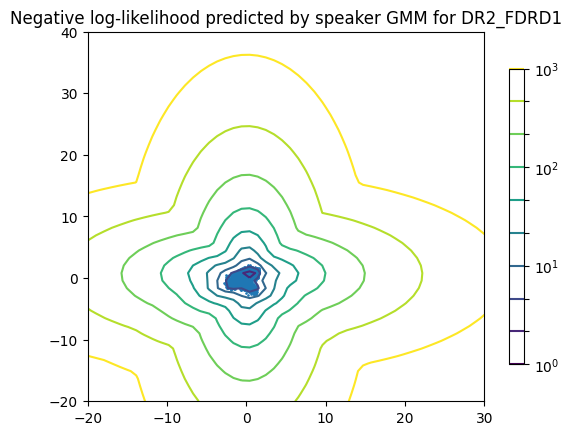

In [ ]:
# train a GMM model on speaker data and plot the GMM density estimation
# gaussian model
# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm
from sklearn import mixture
import matplotlib.pyplot as plt


random_speaker = 'DR2_FDRD1'

GMM_COMPONENTS_r = 5
gmm_r = GMM(n_components = GMM_COMPONENTS_r, covariance_type='diag', n_init = 3)
feature_vect = np.asarray(())

for aud_path in speakers_data[random_speaker]:
  sr, speaker_aud = read(aud_path)
  speaker_feat = extract_features(speaker_aud, sr)
  if feature_vect.size == 0:
    feature_vect = speaker_feat
  else:
    feature_vect = np.vstack((feature_vect, speaker_feat))

feature_vect = feature_vect[:, :2]
# train
gmm_r.fit(feature_vect)

x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_r.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(feature_vect[:, 0], feature_vect[:, 1], 0.8)

plt.title(f"Negative log-likelihood predicted by speaker GMM for {random_speaker}")
plt.axis("tight")
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
from re import S
from math import inf
from sklearn.metrics import accuracy_score
# test model
# given a speaker id, compare with all the audio of same speaker [same label],
# and randomly sample some audio from other speakers, get accuracy for that speaker
import random, math

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib.colors import LogNorm
from sklearn import mixture

from scipy.stats import norm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from scipy.optimize import curve_fit

# gaussian fit
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

def calc_eer(y, y_score):
  fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)

  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)

  return eer, thresh

def test_model(speakers_data, gmm_speakers, speaker_id):
  # from speakers data, make test sets
  test_set = []
  labels = []
  # same speaker data, label 1
  for aud_p in speakers_data[speaker_id]:
    test_set.append([aud_p, 1])
    labels.append(1)
  for other_sp in speakers_data:
    if other_sp != speaker_id:
      aud_p = random.sample(speakers_data[other_sp], 1)[0]
      test_set.append([aud_p, 0])
      labels.append(0)

  # anchor audio [not needed]
  anchor_aud = speakers_data[speaker_id][0] # the first audio
  sr, a_aud = read(anchor_aud)
  anchor_feat = extract_features(a_aud, sr)

  # scoring
  pred_labels = []
  pred_scores = []
  pred_scores_0 = []
  pred_scores_1 = []
  for test in test_set:
    aud_p, lab = test
    sr, aud = read(aud_p)
    speaker_feat = extract_features(aud, sr)

    max_score = - inf
    predicted_speaker = None
    for spk in gmm_speakers:
      gmm = gmm_speakers[spk]
      score = np.array(gmm.score(speaker_feat)).sum()
      if score > max_score:
        max_score = score
        predicted_speaker = spk
      if spk == speaker_id:
        pred_scores.append(score)
        if lab == 1:
          pred_scores_1.append(score)
        else:
          pred_scores_0.append(score)

    if predicted_speaker == speaker_id:
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  acc = accuracy_score(labels, pred_labels)
  eer, th = calc_eer(labels, pred_scores)
  print(f"accuracy score for {speaker_id}: {acc * 100.}%")
  print(f"eer score for {speaker_id}: {eer * 100.}% with threshold {th}")

  print(classification_report(labels, pred_labels))

  # Get ROC curve FPR and TPR from true labels vs score values
  fpr, tpr, _ = roc_curve(labels, pred_scores)

  # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
  roc_auc = auc(fpr, tpr)

  # Calculate precision and recall from true labels vs score values
  precision, recall, _ = precision_recall_curve(labels, pred_scores)

  plt.figure(figsize=(8, 3))

  plt.subplot(1,2,1)
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.step(recall, precision, color='orange', where='post')
  # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision Recall Curve')
  plt.grid(True)

  plt.show()

  # try:
  #   n = min(len(pred_scores_0), len(pred_scores_1))
  #   # negative
  #   bin_heights, bin_borders, _ = plt.hist(pred_scores_0[:n], color = 'r', bins='auto', label='imposter')
  #   bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
  #   popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

  #   x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
  #   plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='imposter_curve')

  #   # positive
  #   bin_heights, bin_borders, _ = plt.hist(pred_scores_1[:n], color = 'b', bins='auto', label='genuine')
  #   bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
  #   popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

  #   x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
  #   plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='genuine_curve')
  #   plt.legend()
  #   plt.show()
  # except:
  #   print("The hist was not plotted.")
  return acc, eer, labels, pred_labels, pred_scores

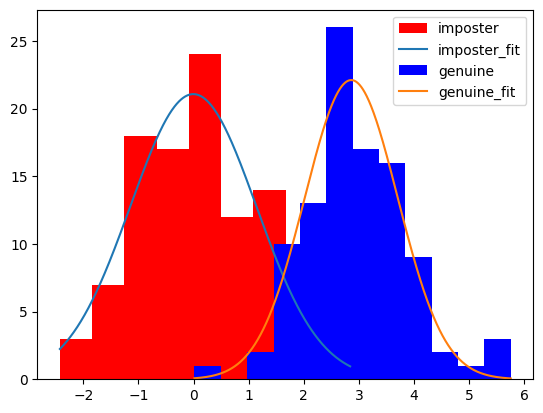

In [ ]:
from scipy.optimize import curve_fit
x = np.random.randn(100)
y = 3 + np.random.randn(100)
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

# negative
bin_heights, bin_borders, _ = plt.hist(x, color = 'r', bins='auto', label='imposter')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='imposter_fit')

# positive
bin_heights, bin_borders, _ = plt.hist(y, color = 'b', bins='auto', label='genuine')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='genuine_fit')
plt.legend()
plt.show()

accuracy score for DR2_FDRD1: 100.0%
eer score for DR2_FDRD1: 5.38922155686872% with threshold -7.30874291798902
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        10

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



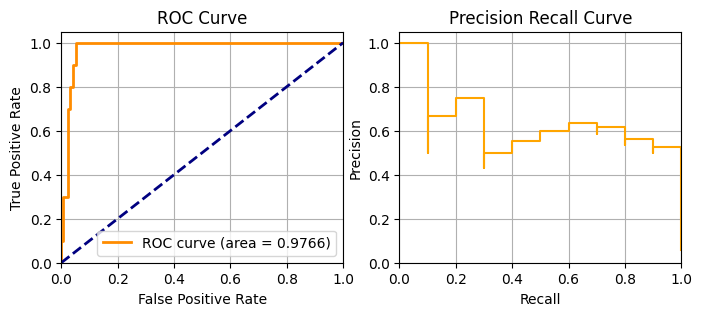

In [ ]:
acc, eer, _, _, _ = test_model(speakers_data, gmm_speakers, 'DR2_FDRD1')

In [ ]:
# plotting in 2-d for visualization
# do feature extraction, manifold, and 3d plot
from sklearn import manifold

all_features = []
all_labs = []

for speaker_id in tqdm(speakers_data):

  for aud_path in speakers_data[speaker_id]:
    sr, speaker_aud = read(aud_path)
    speaker_feat = extract_features(speaker_aud, sr)
    # print(speaker_feat.shape)
    n = speaker_feat.shape[0]
    total_mid_comp = 150
    c_fv = speaker_feat[ n // 2 - total_mid_comp //2 : n // 2 + total_mid_comp //2 , :].flatten() # central features
    if c_fv.shape[0] == 6000: # 150 [total_mid_comp] x 40 [feature_dim]
      all_features.append(c_fv)
      all_labs.append(speaker_id)

all_features = np.array(all_features)
print(all_features.shape)
print(len(all_labs))

100%|██████████| 168/168 [00:32<00:00,  5.11it/s]


(1666, 6000)
1666


In [ ]:
# generate colors
import random

color_map = {}
for spk in speakers_data:
  color_map[spk] = [(random.randint(0,255)/255., random.randint(0,255)/255., random.randint(0,255)/255.)]

In [ ]:
print(color_map)

{'DR1_MJSW0': [(0.6901960784313725, 0.1843137254901961, 0.36470588235294116)], 'DR1_FJEM0': [(0.7490196078431373, 0.8431372549019608, 0.4392156862745098)], 'DR1_MRJO0': [(0.5411764705882353, 0.08235294117647059, 0.6274509803921569)], 'DR1_FAKS0': [(0.592156862745098, 0.5803921568627451, 0.5372549019607843)], 'DR1_MSJS1': [(0.5411764705882353, 0.7333333333333333, 0.23137254901960785)], 'DR1_MREB0': [(0.00392156862745098, 0.45098039215686275, 0.7529411764705882)], 'DR1_MDAB0': [(0.30980392156862746, 0.25882352941176473, 0.2980392156862745)], 'DR1_MSTK0': [(0.16470588235294117, 0.3764705882352941, 0.3764705882352941)], 'DR1_FELC0': [(0.8313725490196079, 0.6078431372549019, 0.7803921568627451)], 'DR1_FDAC1': [(0.25098039215686274, 0.2980392156862745, 0.45098039215686275)], 'DR1_MWBT0': [(0.4627450980392157, 0.8352941176470589, 0.615686274509804)], 'DR7_MRMS1': [(0.37254901960784315, 0.0, 0.6470588235294118)], 'DR7_MRCS0': [(0.7647058823529411, 0.8274509803921568, 0.6980392156862745)], 'DR7

In [ ]:
# manifold learning
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Y = manifold.MDS(n_components = 3, max_iter=100, n_init=1).fit_transform(all_features)

fig = plt.figure()
ax = Axes3D(fig)

for j in range(len(all_labs)):
  ax.scatter(Y[j,0],Y[j,1],Y[j,2], color = color_map[all_labs[j]])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

accuracy score for DR1_MJSW0: 100.0%
eer score for DR1_MJSW0: 2.994011976088642% with threshold -6.53679199120106
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        10

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



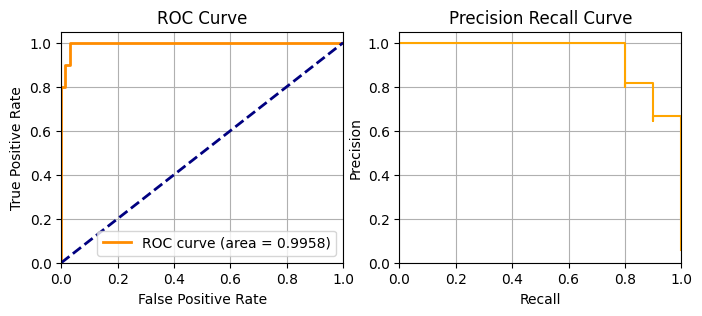

accuracy score for DR1_FJEM0: 99.43502824858757%
eer score for DR1_FJEM0: 2.395209580971737% with threshold -6.97962990581897
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       167
           1       1.00      0.90      0.95        10

    accuracy                           0.99       177
   macro avg       1.00      0.95      0.97       177
weighted avg       0.99      0.99      0.99       177



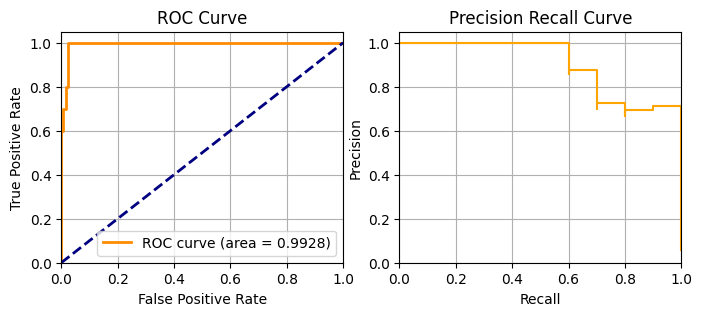

accuracy score for DR1_MRJO0: 100.0%
eer score for DR1_MRJO0: 4.790419161716221% with threshold -7.532220663791758
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        10

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



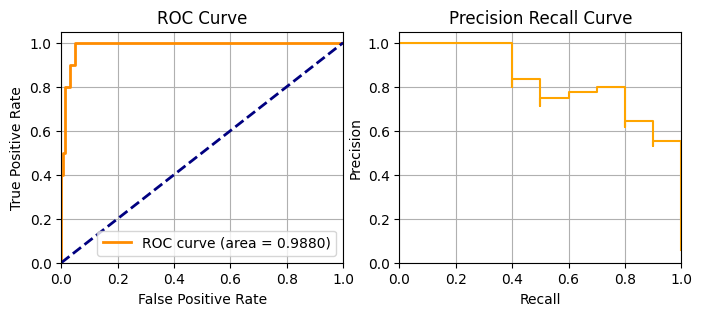

accuracy score for DR1_FAKS0: 100.0%
eer score for DR1_FAKS0: 2.3952095808656737% with threshold -8.106634297835136
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        10

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



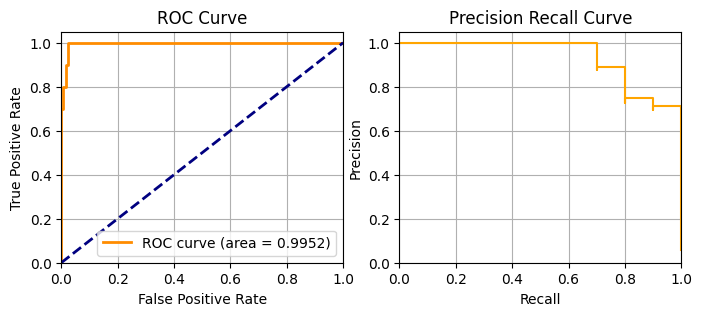

accuracy score for DR1_MSJS1: 100.0%
eer score for DR1_MSJS1: 2.994011976109049% with threshold -6.1890569081256395
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        10

    accuracy                           1.00       177
   macro avg       1.00      1.00      1.00       177
weighted avg       1.00      1.00      1.00       177



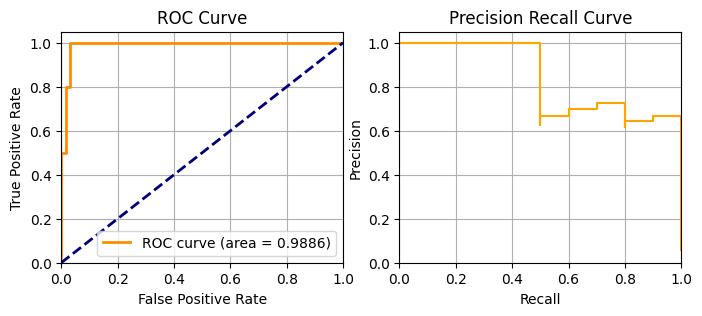

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
Final average test accuracy: 2.9728275490987355%
Final average test EER: 0.09267179926042453%
Final accuracy score for all speakers: 99.88700564971752%
Final eer score for all speakers: 7.9999999999999964%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       835
           1       1.00      0.98      0.99        50

    accuracy                           1.00       885
   macro avg       1.00      0.99      0.99       885
weighted avg       1.00      1.00      1.00       885



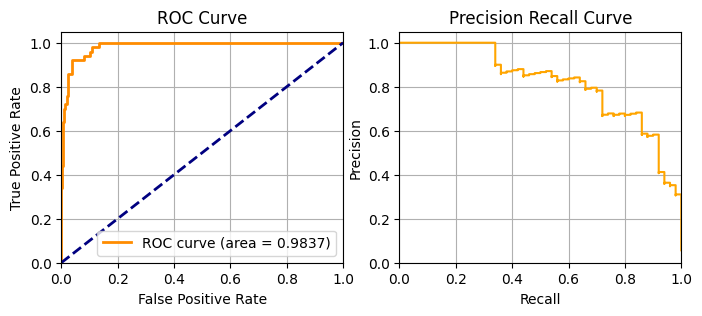

In [ ]:
# testing for all speakers
tot_acc = 0.0
tot_eer = 0.0

all_labs = []
all_pred_labs = []
all_pred_scores = []

dummy_run = True # make it False for full run

for j, spk in enumerate(speakers_data):
  if dummy_run and j == 5:
    break
  acc, eer, labs, pred_labs, pred_scores = test_model(speakers_data, gmm_speakers, spk)
  tot_acc += acc
  tot_eer += eer
  all_labs.extend(labs)
  all_pred_labs.extend(pred_labs)
  all_pred_scores.extend(pred_scores)

print('------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------')

print(f"Final average test accuracy: {tot_acc/len(list(speakers_data.keys()))*100.}%")
print(f"Final average test EER: {tot_eer/len(list(speakers_data.keys()))*100.}%")

acc = accuracy_score(all_labs, all_pred_labs)
eer, th = calc_eer(all_labs, all_pred_scores)
print(f"Final accuracy score for all speakers: {acc * 100.}%")
print(f"Final eer score for all speakers: {eer * 100.}%")

print(classification_report(all_labs, all_pred_labs))

# Get ROC curve FPR and TPR from true labels vs score values
fpr, tpr, _ = roc_curve(all_labs, all_pred_scores)

# Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
roc_auc = auc(fpr, tpr)

# Calculate precision and recall from true labels vs score values
precision, recall, _ = precision_recall_curve(all_labs, all_pred_scores)

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1,2,2)
plt.step(recall, precision, color='orange', where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve')
plt.grid(True)

plt.show()

In [ ]:
pip install colab-convert


  Preparing metadata (setup.py) ... done
  Created wheel for colab-convert: filename=colab_convert-2.0.5-py3-none-any.whl size=19207 sha256=4f4befcb3d586e33bccdcf9933f0134f7d54c12d8769f7f73c511e72dc13c150
  Stored in directory: /root/.cache/pip/wheels/a7/9f/0a/70f4be5eeba4a3fca9d7bcf68d5a4e97edb9f22be449cc1e8c
Successfully built colab-convert


In [ ]:
help(extract_features)

Help on function extract_features in module __main__:

extract_features(audio, rate)
    extract 20 dim mfcc features from an audio, performs CMS and combines
    delta to make it 40 dim feature vector

